In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
import re
from sklearn.preprocessing import OrdinalEncoder
from functools import reduce
import statistics

In [2]:
# Path con los datasets iniciales
os.chdir('D:/Documents/UPM/Actual/TFG/LEMD/DataSets')
#os.chdir('C:/Users/aalfaro/Documents/Meteo/TFG/LEMD/DataSets')

# pd.options.display.max_rows = 50
# pd.options.display.max_columns = 50

# pd.set_option('display.float_format', lambda x: '%.10f' % x)

plt.rcParams['figure.figsize'] = (18,7)
        
sns.set_theme(style = 'whitegrid')

In [3]:
def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        plot_width, plot_height = (18,7)
        plt.rcParams['figure.figsize'] = (plot_width,plot_height)
        missing_data.plot(kind = "barh")
    else:
        print('No NAs found')

In [4]:
# Dataset con la información miscelanea
th_df = pd.read_csv('Threshold.csv', header = 0, decimal = ',', sep = ';')

dtypes = { 'date': 'datetime64[ns]', 'dateTimeStart': 'datetime64[ns]', 'dateTimeEnd': 'datetime64[ns]', 'm4_speed': 'float64'}
th_df = th_df.astype(dtypes)

th_df = th_df.drop_duplicates()
th_df = th_df.drop_duplicates(subset = ['flight_key', 'threshold_separation'])
th_df = th_df.drop(['ICAO', 'prev_flight_wake'], axis=1)

th_df = th_df[th_df.arr_volume_group == 'ALTA']

In [5]:
th_df.rename(columns = {'dateTimeStart':'dateTime', 'dateTimeEnd':'next_dateTime'}, inplace = True)

th_df.loc[(th_df['m4_altitude'] >= 27), 'm4_altitude'] = '27+'

th_df.loc[(th_df['runway'] == '32R') | (th_df['runway'] == '32L'), 'runway'] = '32'
th_df.loc[(th_df['runway'] == '18R') | (th_df['runway'] == '18L'), 'runway'] = '18'

#th_df

In [6]:
# Dataset con la información miscelanea
mc_df = pd.read_csv('Miscellaneous.csv', header = 0, decimal = ',', sep = ';')

dtypes = { 'dateTime': 'datetime64[ns]', 'next_dateTime': 'datetime64[ns]'}
mc_df = mc_df.astype(dtypes)

mc_df = mc_df.drop_duplicates()
mc_df = mc_df[(~mc_df.duplicated(['dateTime'])) | mc_df.duplicated(['dateTime','metarKey'])]
mc_df = mc_df.drop(['dep_volume_group', 'volume_group', 'unitPressure', 'dirMinVisibility', 'verVisibility', 'gustyWind', 'dewPoint', 'oscillationFrom', 'oscillationTo'], axis=1)

mc_df['visibility'] = mc_df.apply(lambda row: 9999 if row['CAVOK'] == 1 else row['visibility'], axis = 1)

cavok_mt = set(mc_df[mc_df.CAVOK == 1].metarKey)

In [7]:
mc_df.fillna(value = {'minVisibility': mc_df.visibility, 'knots': 0, 'maxKnots': mc_df.knots + 5}, inplace=True)
mc_df = mc_df.drop(['visibility'], axis=1)
mc_df.rename(columns = {'minVisibility':'visibility'}, inplace = True)

mc_df['knotsVariability'] = mc_df.apply(lambda row: row['maxKnots'] - row['knots'], axis = 1)

while mc_df['direction'].isna().sum() != 0:
    mc_df['direction'] = np.where(pd.isna(mc_df['direction']), mc_df['direction'].shift(1), mc_df['direction'])

#mc_df

In [8]:
# Dataset con la información de nubes
cd_df = pd.read_csv('Clouds.csv', header = 0, decimal = ',', sep = ';')

dtypes = { 'dateTime': 'datetime64[ns]', 'next_dateTime': 'datetime64[ns]'}
cd_df = cd_df.astype(dtypes)

cd_df = cd_df.drop_duplicates()
cd_df = cd_df[(~cd_df.duplicated(['dateTime'])) | cd_df.duplicated(['dateTime','metarKey'])]
cd_df = cd_df.drop(['dep_volume_group', 'volume_group'], axis=1)

cd_df['noSignificantClouds'] = cd_df.apply(lambda row: int(row.metarKey in cavok_mt), axis = 1)
cd_df['noCloudDetected'] = cd_df.apply(lambda row: int(row.metarKey in cavok_mt), axis = 1)
cd_df['type'] = cd_df.apply(lambda row: 'NONE' if row.metarKey in cavok_mt else row['type'], axis = 1)

In [9]:
# Se cambian los posibles null de las nubes
cd_df.fillna(value = {'amount': 'NONE', 'height': 999, 'type': 'NONE'}, inplace=True)

# Se divide el dataframe de las nuebes en 2 para procesarlos
cld1 = pd.DataFrame(cd_df, columns = ['dateTime', 'next_dateTime', 'metarKey', 'arr_volume_group', 'amount', 'height'])
cld2 = pd.DataFrame(cd_df, columns = ['dateTime', 'next_dateTime', 'metarKey', 'arr_volume_group', 'noSignificantClouds', 'noCloudDetected', 'type'])

In [10]:
# Se codifican la altura y la cantidad de nubes
enc = OrdinalEncoder(categories = [['NONE', 'FEW', 'SCT', 'BKN', 'OVC']])
cld1.loc[:, ['amount']] = enc.fit_transform(cld1[['amount']])

# Se seleccionan las nubes con menor altura
minh = cld1.loc[cld1.groupby('metarKey').height.idxmin()]
minh.rename(columns = {'amount':'min_height_amount', 'height':'min_height'}, inplace = True)

# Se seleccionan las nubes mas densas
maxa = cld1.loc[cld1.groupby('metarKey').amount.idxmax()]
maxa.rename(columns = {'amount':'max_amount', 'height':'max_amount_height'}, inplace = True)

# Se combinan ambos dataSets
cld1 = pd.merge(minh, maxa, on = ['metarKey', 'dateTime', 'next_dateTime', 'arr_volume_group'], how = 'inner')

In [11]:
# Se codifican los tipos de nubes
cld2['significantClouds'] = cld2.apply(lambda row: int((row.type == 'TCU') | (row.type == 'CB')), axis = 1)

# Se agrupan las filas multiplexadas
cld2 = cld2.groupby(cld2.metarKey, as_index=False, axis = 0).max(0)

cld2['anyClouds'] = cld2.apply(lambda row: 1 - max(row.noSignificantClouds, row.noCloudDetected), axis = 1)

cld2 = cld2.drop(['type', 'noSignificantClouds', 'noCloudDetected'], axis=1)

In [12]:
cd_df = pd.merge(cld1, cld2, on = ['metarKey', 'dateTime', 'next_dateTime', 'arr_volume_group'], how = 'inner')

#cd_df

In [13]:
# Dataset con la información de fenomenos
ph_df = pd.read_csv('Phenomena.csv', header = 0, decimal = ',', sep = ';')

dtypes = { 'dateTime': 'datetime64[ns]', 'next_dateTime': 'datetime64[ns]'}
ph_df = ph_df.astype(dtypes)

ph_df = ph_df.drop_duplicates()
ph_df = ph_df[(~ph_df.duplicated(['dateTime'])) | ph_df.duplicated(['dateTime','metarKey'])]
ph_df = ph_df.drop(['dep_volume_group', 'volume_group', 'noPhenDetected', 'recent'], axis=1)

lluvia_mt = set(ph_df[ph_df.phenomenon1 == 'Lluvia'].metarKey)

In [14]:
# Se codifican los fenomenos
ph_df.fillna(value = {'intensity': 'NONE'}, inplace = True)

ph_df.loc[(ph_df.intensity == 'En proximidades'), 'intensity'] = 'Moderado'

# Se codifican la intesidad
enc = OrdinalEncoder(categories = [['NONE', 'Baja', 'Moderado', 'Fuerte']])
ph_df.loc[:, ['intensity']] = enc.fit_transform(ph_df[['intensity']])

# Se selecciona los fenomenos de lluvia asociados a su intesidad
ph_df['Lluvia'] = np.where(ph_df[['phenomenon1', 'phenomenon2', 'phenomenon3']].eq('Lluvia').any(1, skipna=True)
                         | ph_df[['phenomenon1', 'phenomenon2', 'phenomenon3']].eq('Llovizna').any(1, skipna=True)
                         , 0 + ph_df.intensity
                         , 0)

# Se selecciona los fenomenos de niebla asociados a su intesidad
ph_df['Niebla'] = np.where(ph_df[['phenomenon1', 'phenomenon2', 'phenomenon3']].eq('Niebla').any(1, skipna=True)
                         | ph_df[['phenomenon1', 'phenomenon2', 'phenomenon3']].eq('Neblina').any(1, skipna=True)
                         , 0 + ph_df.intensity
                         , 0)

# Se selecciona los fenomenos de tormentas asociados a su intesidad
ph_df['Tormenta'] = np.where(ph_df[['characteristic']].eq('Tormenta').any(1, skipna=True)
                            , 0 + ph_df.intensity
                            , 0)

ph_df.drop(['intensity', 'characteristic', 'phenomenon1', 'phenomenon2', 'phenomenon3'], axis = 1, inplace = True)

# Se agrupan las filas multiplexadas
ph_df = ph_df.groupby(ph_df.metarKey, as_index = False, axis = 0).max()

#ph_df

In [15]:
# Dataset con la información de pista
rn_df = pd.read_csv('Runway.csv', header = 0, decimal = ',', sep = ';')

dtypes = { 'dateTime': 'datetime64[ns]', 'next_dateTime': 'datetime64[ns]'}
rn_df = rn_df.astype(dtypes)

rn_df = rn_df.drop_duplicates()
rn_df = rn_df[(~rn_df.duplicated(['dateTime'])) | rn_df.duplicated(['dateTime','metarKey'])]
rn_df = rn_df.drop(['dep_volume_group', 'volume_group', 'RVR', 'tendencyRVR', 'dimCoverage', 'heightCoverage', 'frictionCoefficient'], axis=1)

rn_df.fillna(value = {'coverage': 0}, inplace=True)
rn_df['coverage'] = rn_df.apply(lambda row: 1 if (row.metarKey in lluvia_mt) & (row.coverage == 0) else row['coverage'], axis = 1)

In [16]:
rn_df.fillna(value = {'runwayName': 'ALL', 'shear': 0}, inplace=True)

rn_df.loc[(rn_df['runwayName'] == '32R') | (rn_df['runwayName'] == '32L'), 'runwayName'] = '32'
rn_df.loc[(rn_df['runwayName'] == '18R') | (rn_df['runwayName'] == '18L'), 'runwayName'] = '18'

rn_df = rn_df[(rn_df['runwayName'] == '32') | (rn_df['runwayName'] == '18') | (rn_df['runwayName'] == 'ALL')]

aux = rn_df[rn_df.runwayName == 'ALL']
rn_df.loc[rn_df['runwayName'] == 'ALL', 'runwayName'] = '32'
aux.loc[aux['runwayName'] == 'ALL', 'runwayName'] = '18'
rn_df = pd.concat([rn_df, aux])

rn_df = rn_df.groupby(['dateTime', 'next_dateTime', 'arr_volume_group', 'metarKey', 'runwayName'], as_index = False, axis = 0).max()

rn_df = rn_df.rename(columns = {'runwayName':'runway'})

#rn_df

C:\Users\AdrianAD\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [17]:
dfs = [mc_df, cd_df, ph_df]

# Merge de los dataframes
metar_df = reduce(lambda left, right : pd.merge(left, right, on = ['dateTime', 'next_dateTime', 'metarKey', 'arr_volume_group'], how = 'inner'), dfs)

all_df = pd.merge(th_df, metar_df, on = ['dateTime', 'next_dateTime', 'arr_volume_group'], how = 'inner')

final_df = pd.merge(all_df, rn_df, on = ['dateTime', 'next_dateTime', 'arr_volume_group','metarKey','runway'], how = 'inner')

#final_df

32    55184
18    22659
Name: runway, dtype: int64


[Text(0.5, 1.0, 'Runway')]

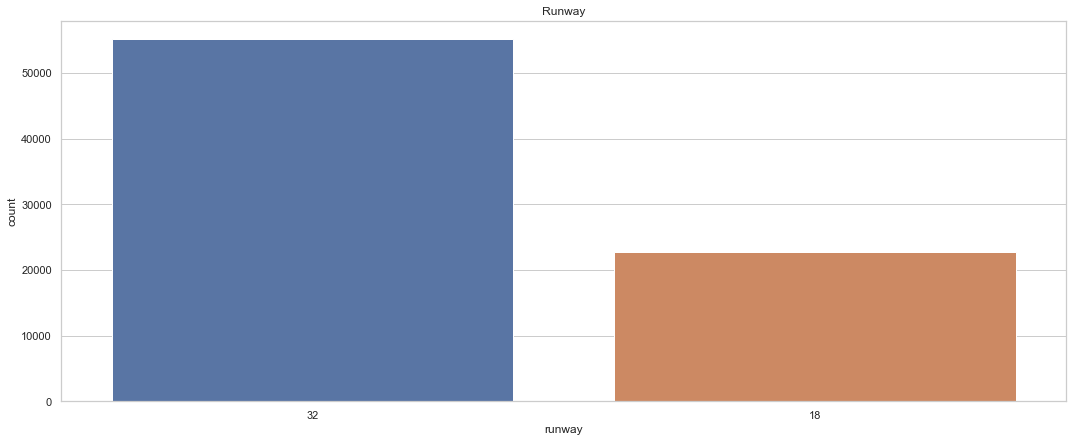

In [18]:
print(final_df['runway'].value_counts())

sns.countplot(data = final_df, x = 'runway').set(title = 'Runway')

In [19]:
n_df = final_df[final_df['runway'] == '32']
s_df = final_df[final_df['runway'] == '18']

In [20]:
#n_mode =  #3.1546845

n_df = n_df.fillna(value = {'diag_distance':statistics.median(n_df.diag_distance)})

n_df['direction'] = n_df.apply(lambda row: row['direction'] - 320 if row['direction'] >= 320 else 360 - 320 + row['direction'], axis = 1)
n_df['direction'] = n_df.apply(lambda row: 360 - row['direction'] if row['direction'] > 180 else row['direction'], axis = 1)

bins = [-1, 30, 60, 120, 150, 180]
names = ['Front','DFront','Lateral','DTail','Tail']
n_df.loc[:, 'direction'] = pd.cut(n_df['direction'], bins, labels = names)

In [21]:
#s_mode =  #1.880002

s_df = s_df.fillna(value = {'diag_distance': statistics.median(s_df.diag_distance)})

s_df['direction'] = s_df.apply(lambda row: row['direction'] - 180 if row['direction'] >= 180 else 360 - 180 + row['direction'], axis = 1)
s_df['direction'] = s_df.apply(lambda row: 360 - row['direction'] if row['direction'] > 180 else row['direction'], axis = 1)

bins = [-1, 30, 60, 120, 150, 180]
names = ['Front','DFront','Lateral','DTail','Tail']
s_df.loc[:, 'direction'] = pd.cut(s_df['direction'], bins, labels = names)

       threshold_separation
count          55184.000000
mean               6.009081
std                1.859961
min                1.521177
25%                4.756498
50%                5.692002
75%                6.811691
max               18.987400


<AxesSubplot:xlabel='threshold_separation'>

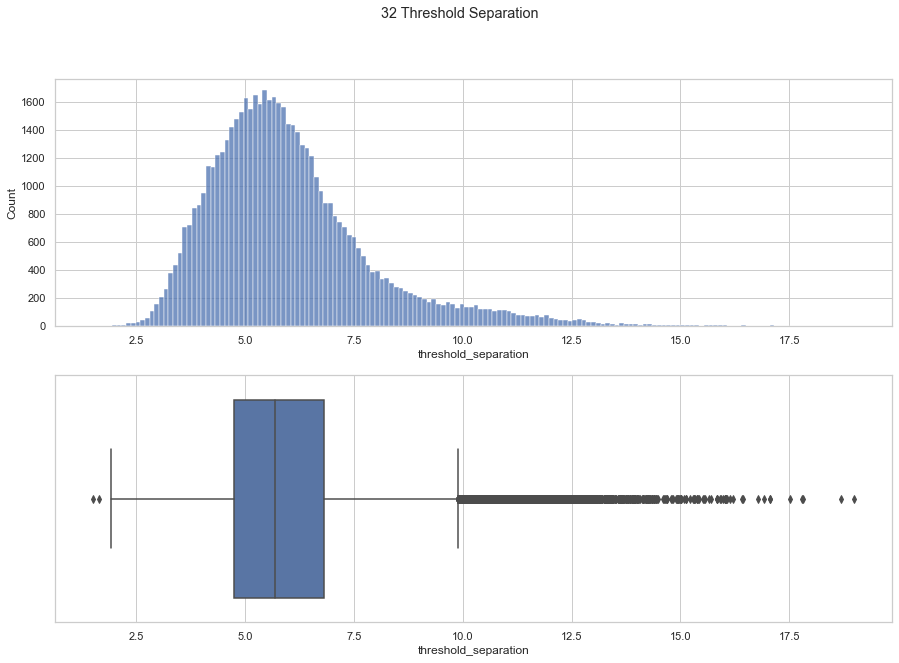

In [22]:
print(n_df[['threshold_separation']].describe())

fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(15, 10))
fig.suptitle('32 Threshold Separation')
sns.histplot(data = n_df, x = 'threshold_separation', ax = axes[0])
sns.boxplot(data = n_df, x = 'threshold_separation', ax = axes[1])

       threshold_separation
count          22659.000000
mean               6.682668
std                2.576095
min                1.666970
25%                4.958271
50%                6.055258
75%                7.632233
max               19.814610


<AxesSubplot:xlabel='threshold_separation'>

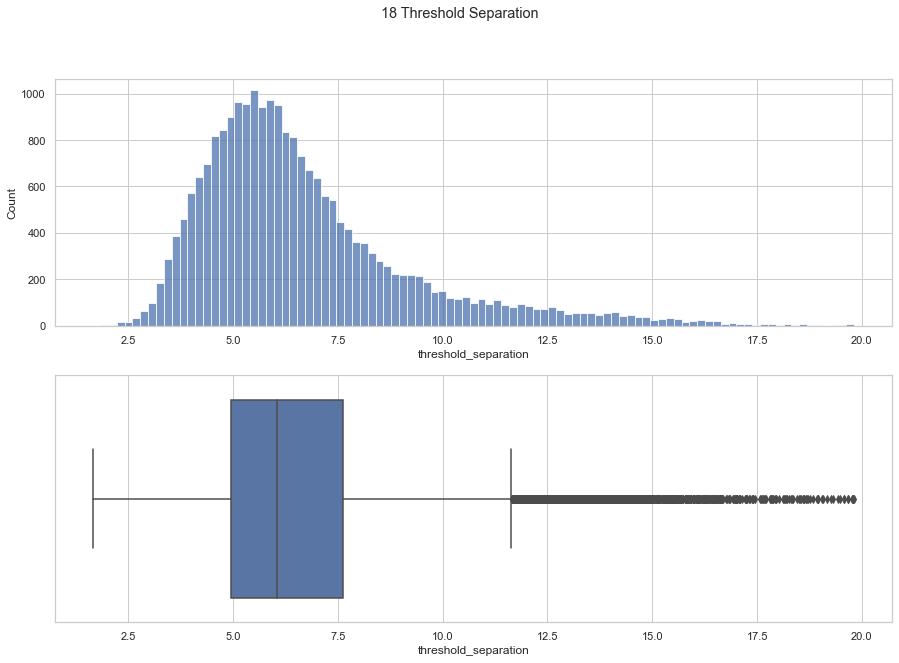

In [23]:
print(s_df[['threshold_separation']].describe())

fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(15, 10))
fig.suptitle('18 Threshold Separation')
sns.histplot(data = s_df, x = 'threshold_separation', ax = axes[0])
sns.boxplot(data = s_df, x = 'threshold_separation', ax = axes[1])

M    47995
H     6748
L      300
J      141
Name: flight_wake, dtype: int64


[Text(0.5, 1.0, '32 Wake')]

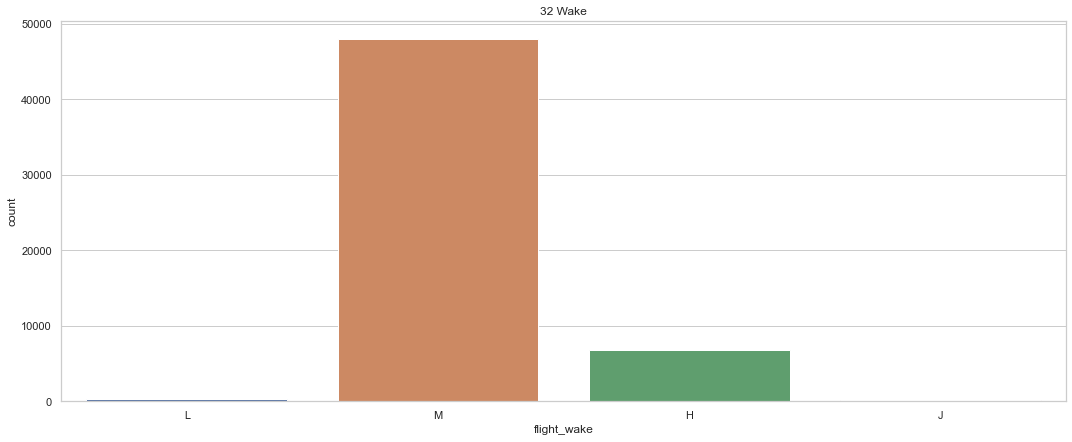

In [24]:
print(n_df['flight_wake'].value_counts())

sns.countplot(data = n_df, x = 'flight_wake', order = ['L','M','H','J']).set(title = '32 Wake')

M    19962
H     2480
L      149
J       68
Name: flight_wake, dtype: int64


[Text(0.5, 1.0, '18 Wake')]

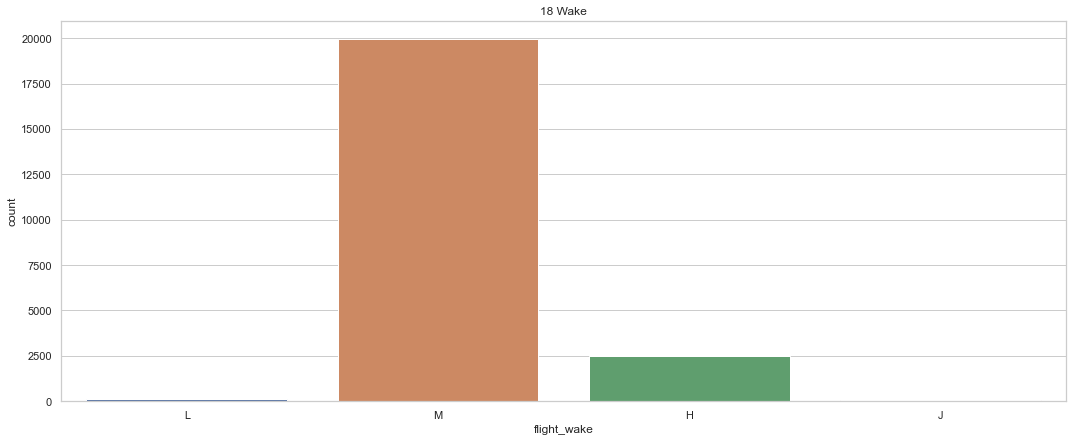

In [25]:
print(s_df['flight_wake'].value_counts())

sns.countplot(data = s_df, x = 'flight_wake', order = ['L','M','H','J']).set(title = '18 Wake')

       diag_distance
count   55184.000000
mean        4.577474
std         3.403626
min         0.925224
25%         2.663894
50%         3.397194
75%         4.516182
max        19.999180


<AxesSubplot:xlabel='diag_distance'>

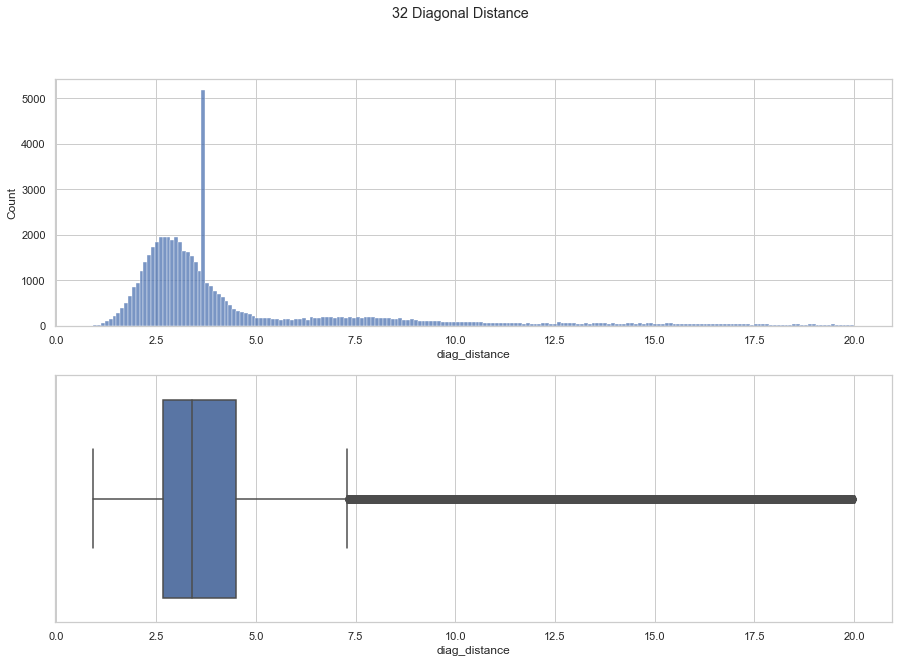

In [26]:
print(n_df[['diag_distance']].describe())

fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(15, 10))
fig.suptitle('32 Diagonal Distance')
sns.histplot(data = n_df, x = 'diag_distance', ax = axes[0])
sns.boxplot(data = n_df, x = 'diag_distance', ax = axes[1])

       diag_distance
count   22659.000000
mean        4.196658
std         3.148573
min         0.653523
25%         2.332143
50%         3.160090
75%         4.572484
max        19.993610


<AxesSubplot:xlabel='diag_distance'>

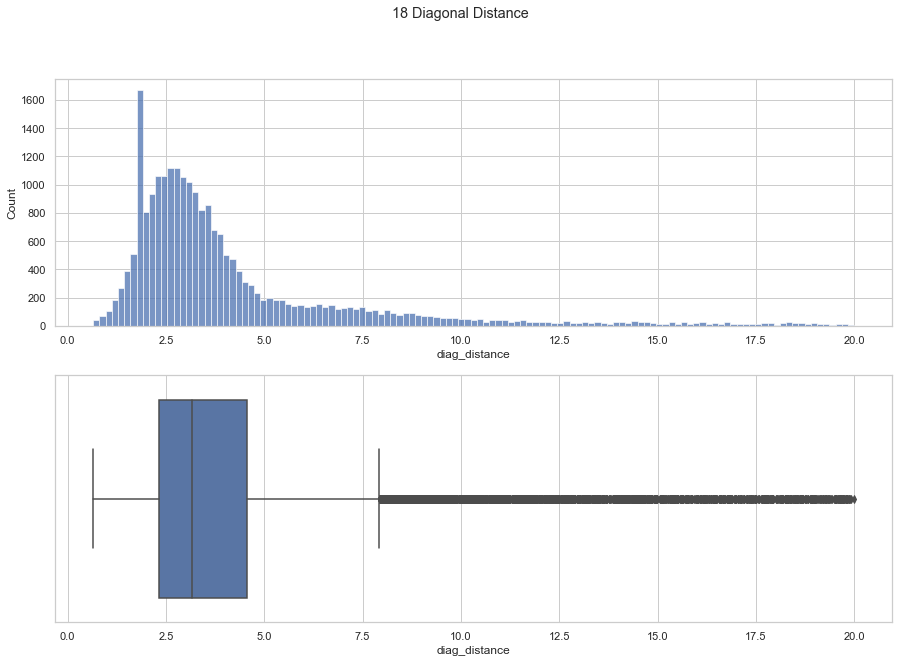

In [27]:
print(s_df[['diag_distance']].describe())

fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(15, 10))
fig.suptitle('18 Diagonal Distance')
sns.histplot(data = s_df, x = 'diag_distance', ax = axes[0])
sns.boxplot(data = s_df, x = 'diag_distance', ax = axes[1])

           m4_speed
count  55184.000000
mean     142.799755
std       10.897830
min       91.951000
25%      136.608000
50%      143.339000
75%      149.932000
max      283.176000


<AxesSubplot:xlabel='m4_speed'>

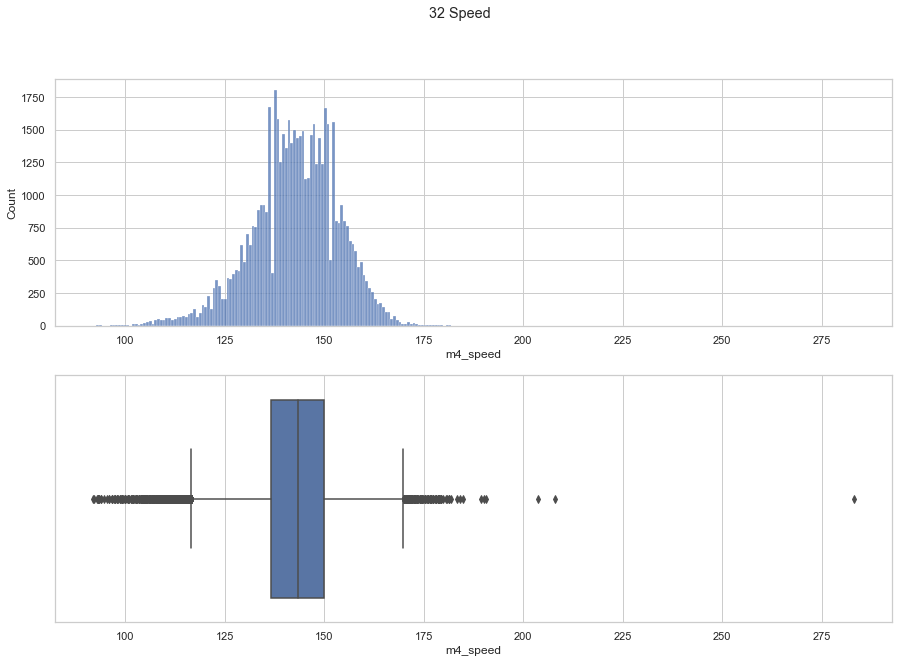

In [28]:
print(n_df[['m4_speed']].describe())

fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(15, 10))
fig.suptitle('32 Speed')
sns.histplot(data = n_df, x = 'm4_speed', ax = axes[0])
sns.boxplot(data = n_df, x = 'm4_speed', ax = axes[1])

           m4_speed
count  22659.000000
mean     140.045606
std       10.743951
min       77.902000
25%      134.091000
50%      140.653000
75%      147.235000
max      187.558000


<AxesSubplot:xlabel='m4_speed'>

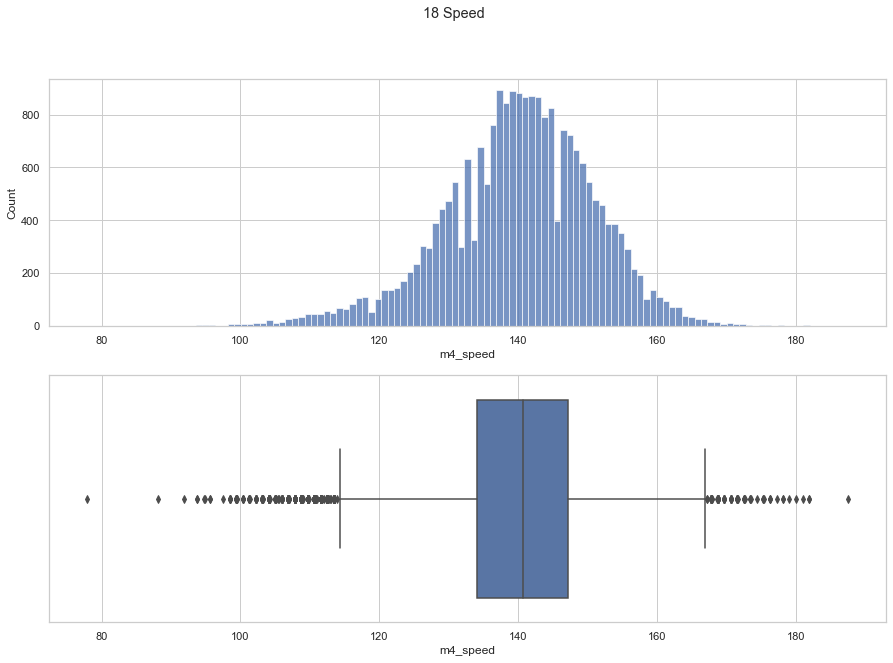

In [29]:
print(s_df[['m4_speed']].describe())

fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(15, 10))
fig.suptitle('18 Speed')
sns.histplot(data = s_df, x = 'm4_speed', ax = axes[0])
sns.boxplot(data = s_df, x = 'm4_speed', ax = axes[1])

20     7982
21     7583
23     7539
22     7488
24     7345
19     6742
25     6366
26     3125
18      588
27+     426
Name: m4_altitude, dtype: int64


[Text(0.5, 1.0, '32 Altitude')]

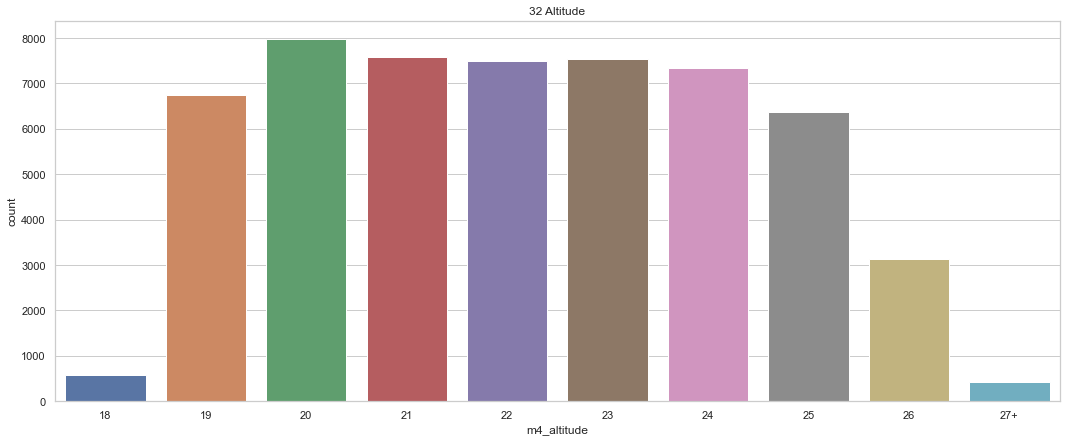

In [30]:
print(n_df['m4_altitude'].value_counts())

sns.countplot(data = n_df, x = 'm4_altitude', order = [18, 19, 20, 21, 22, 23, 24, 25, 26, '27+']).set(title = '32 Altitude')

20     3351
21     3157
23     3154
24     3128
22     3125
25     2906
19     1794
26     1658
27+     349
18       37
Name: m4_altitude, dtype: int64


[Text(0.5, 1.0, '18 Altitude')]

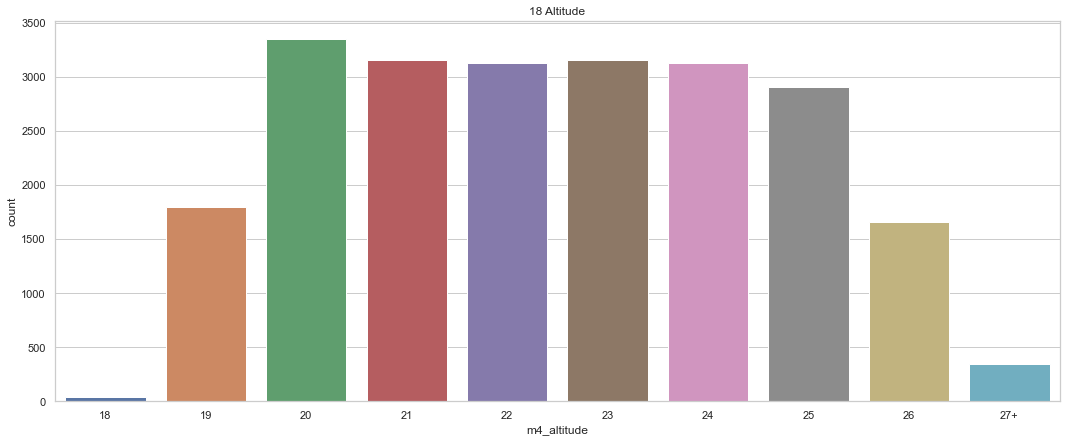

In [31]:
print(s_df['m4_altitude'].value_counts())

sns.countplot(data = s_df, x = 'm4_altitude', order = [18, 19, 20, 21, 22, 23, 24, 25, 26, '27+']).set(title = '18 Altitude')

1    36568
0    18616
Name: CAVOK, dtype: int64


[Text(0.5, 1.0, '32 CAVOK')]

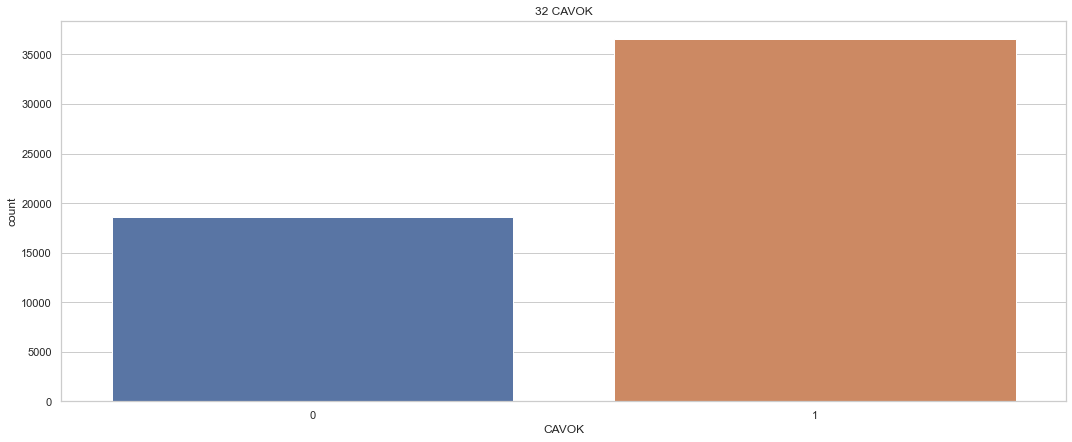

In [32]:
print(n_df['CAVOK'].value_counts())

sns.countplot(data = n_df, x = 'CAVOK').set(title = '32 CAVOK')

1    11973
0    10686
Name: CAVOK, dtype: int64


[Text(0.5, 1.0, '18 CAVOK')]

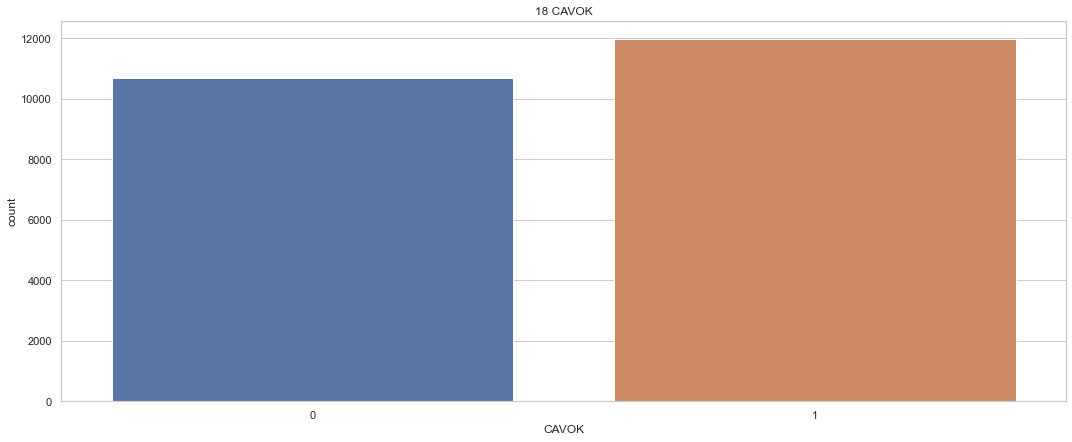

In [33]:
print(s_df['CAVOK'].value_counts())

sns.countplot(data = s_df, x = 'CAVOK').set(title = '18 CAVOK')

         visibility
count  55184.000000
mean    9846.329171
std      864.385200
min      200.000000
25%     9999.000000
50%     9999.000000
75%     9999.000000
max     9999.000000


<AxesSubplot:xlabel='visibility'>

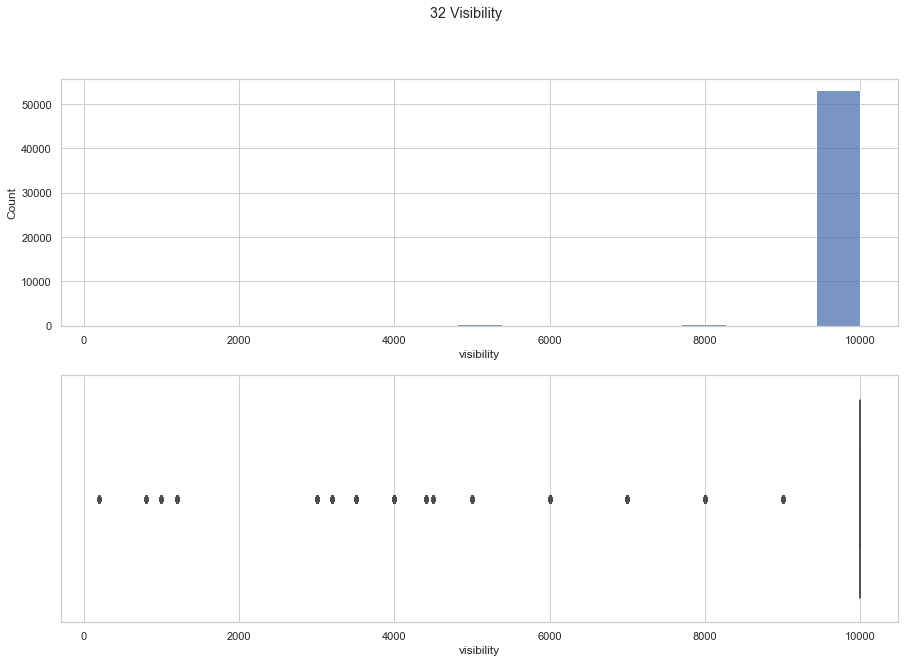

In [34]:
print(n_df[['visibility']].describe())

fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(15, 10))
fig.suptitle('32 Visibility')
sns.histplot(data = n_df, x = 'visibility', ax = axes[0])
sns.boxplot(data = n_df, x = 'visibility', ax = axes[1])

         visibility
count  22659.000000
mean    9886.095944
std      679.542328
min     2400.000000
25%     9999.000000
50%     9999.000000
75%     9999.000000
max     9999.000000


<AxesSubplot:xlabel='visibility'>

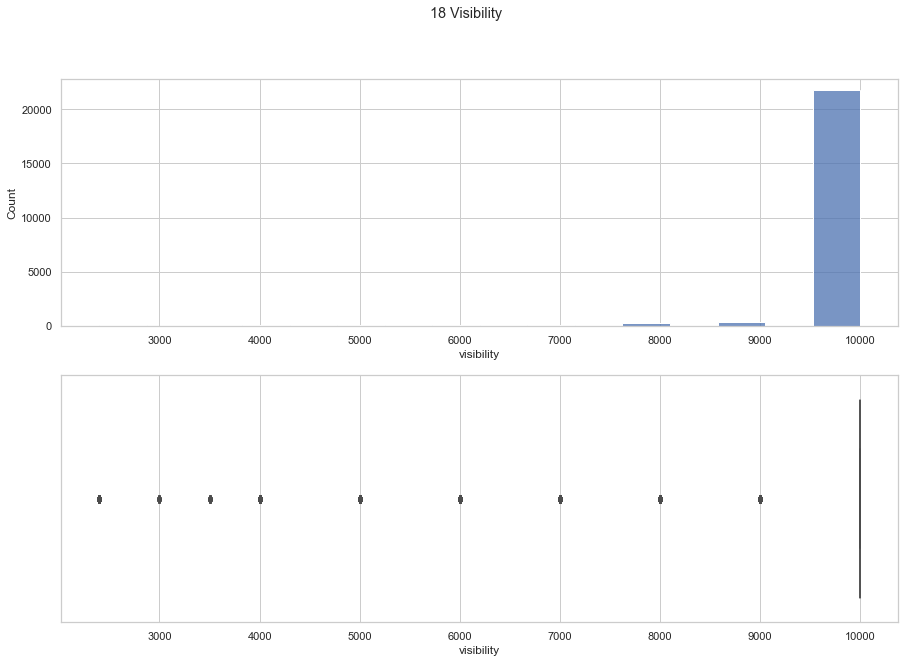

In [35]:
print(s_df[['visibility']].describe())

fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(15, 10))
fig.suptitle('18 Visibility')
sns.histplot(data = s_df, x = 'visibility', ax = axes[0])
sns.boxplot(data = s_df, x = 'visibility', ax = axes[1])

        temperature
count  55184.000000
mean      16.593342
std        8.519359
min       -5.000000
25%       10.000000
50%       16.000000
75%       23.000000
max       39.000000


<AxesSubplot:xlabel='temperature'>

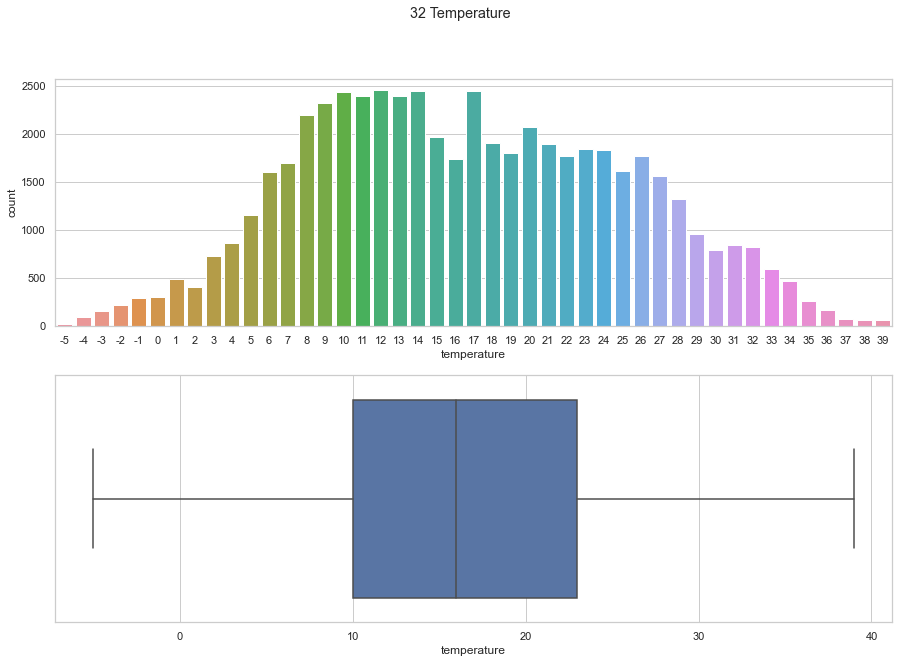

In [36]:
print(n_df[['temperature']].describe())

fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(15, 10))
fig.suptitle('32 Temperature')
sns.countplot(data = n_df, x = 'temperature', ax = axes[0])
sns.boxplot(data = n_df, x = 'temperature', ax = axes[1])

       temperature
count  22659.00000
mean      21.41820
std        9.56763
min        3.00000
25%       12.00000
50%       21.00000
75%       30.00000
max       41.00000


<AxesSubplot:xlabel='temperature'>

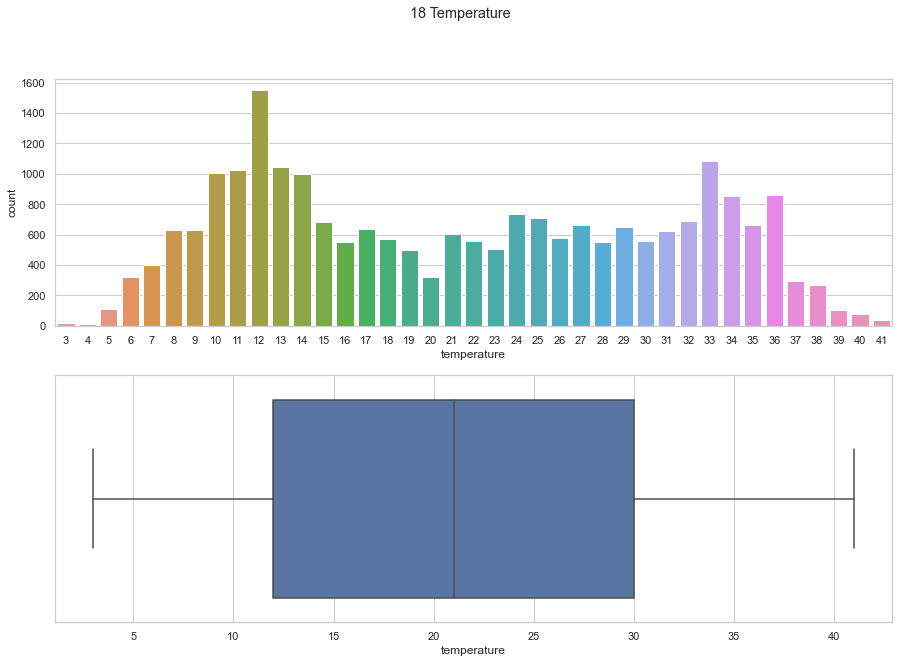

In [37]:
print(s_df[['temperature']].describe())

fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(15, 10))
fig.suptitle('18 Temperature')
sns.countplot(data = s_df, x = 'temperature', ax = axes[0])
sns.boxplot(data = s_df, x = 'temperature', ax = axes[1])

                qnh
count  55184.000000
mean    1018.565653
std        5.930060
min      995.000000
25%     1015.000000
50%     1018.000000
75%     1022.000000
max     1034.000000


<AxesSubplot:xlabel='qnh'>

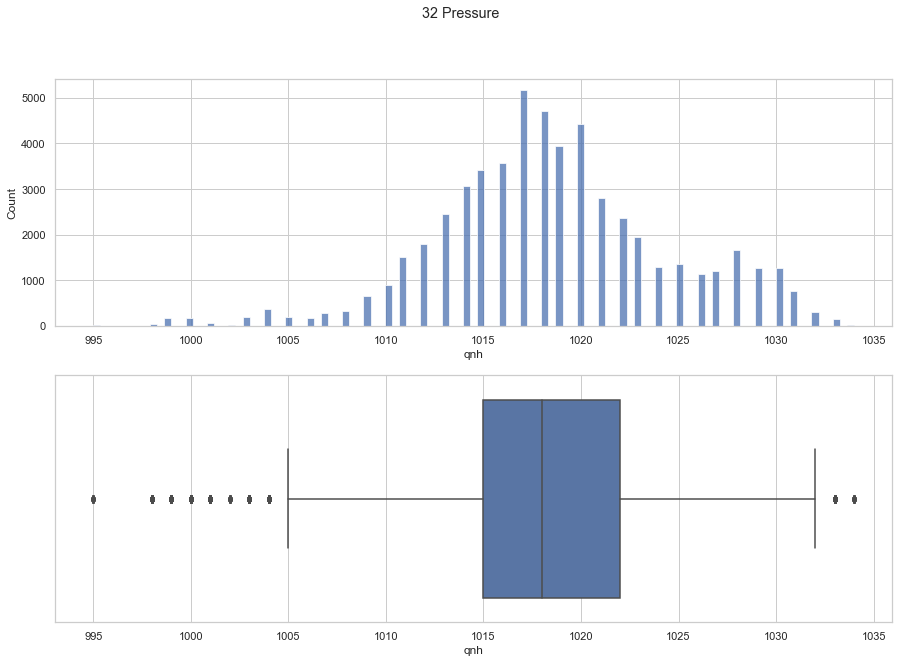

In [38]:
print(n_df[['qnh']].describe())

fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(15, 10))
fig.suptitle('32 Pressure')
sns.histplot(data = n_df, x = 'qnh', ax = axes[0])
sns.boxplot(data = n_df, x = 'qnh', ax = axes[1])

                qnh
count  22659.000000
mean    1014.313518
std        6.773757
min      991.000000
25%     1012.000000
50%     1015.000000
75%     1018.000000
max     1032.000000


<AxesSubplot:xlabel='qnh'>

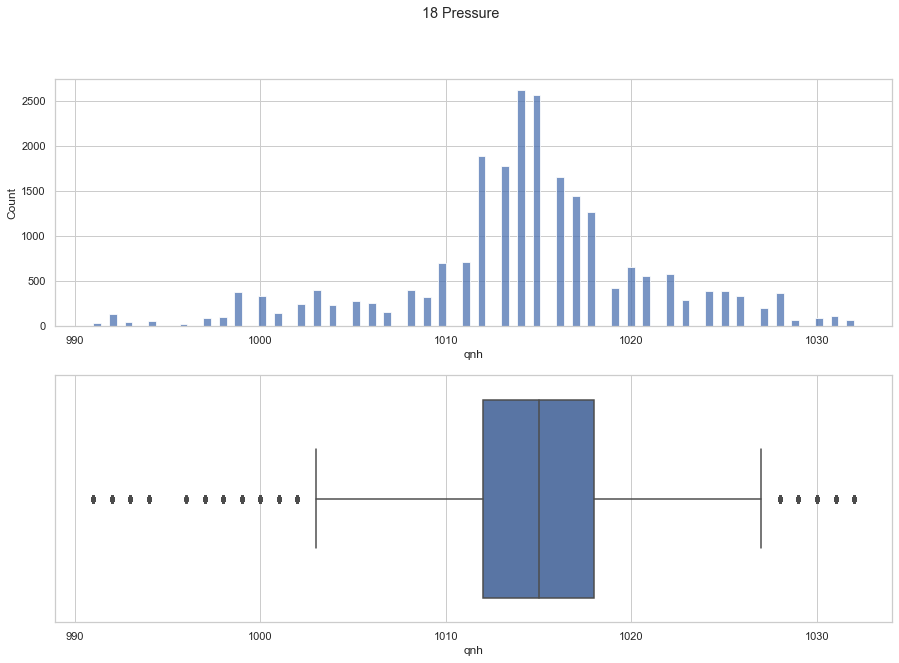

In [39]:
print(s_df[['qnh']].describe())

fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(15, 10))
fig.suptitle('18 Pressure')
sns.histplot(data = s_df, x = 'qnh', ax = axes[0])
sns.boxplot(data = s_df, x = 'qnh', ax = axes[1])

0    47389
1     7795
Name: variable, dtype: int64


[Text(0.5, 1.0, '32 Variable Wind')]

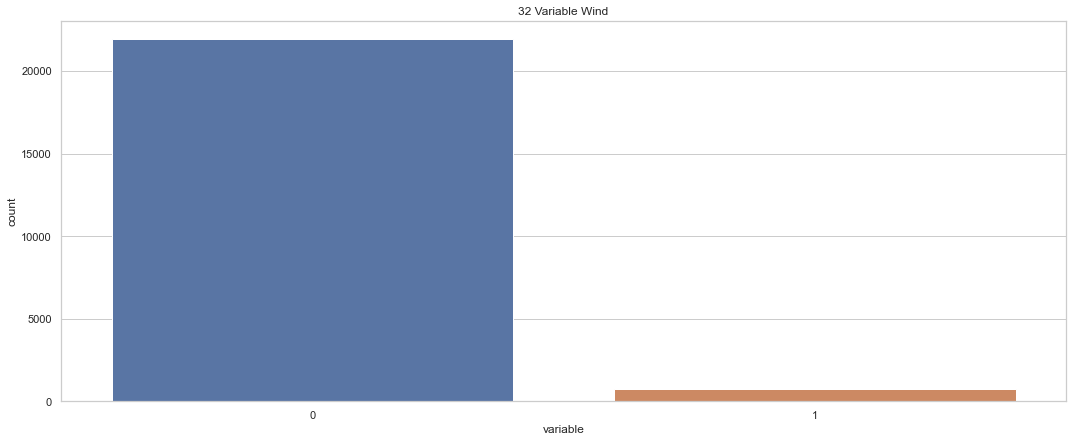

In [40]:
print(n_df['variable'].value_counts())

sns.countplot(data = s_df, x = 'variable').set(title = '32 Variable Wind')

0    21939
1      720
Name: variable, dtype: int64


[Text(0.5, 1.0, '18 Variable Wind')]

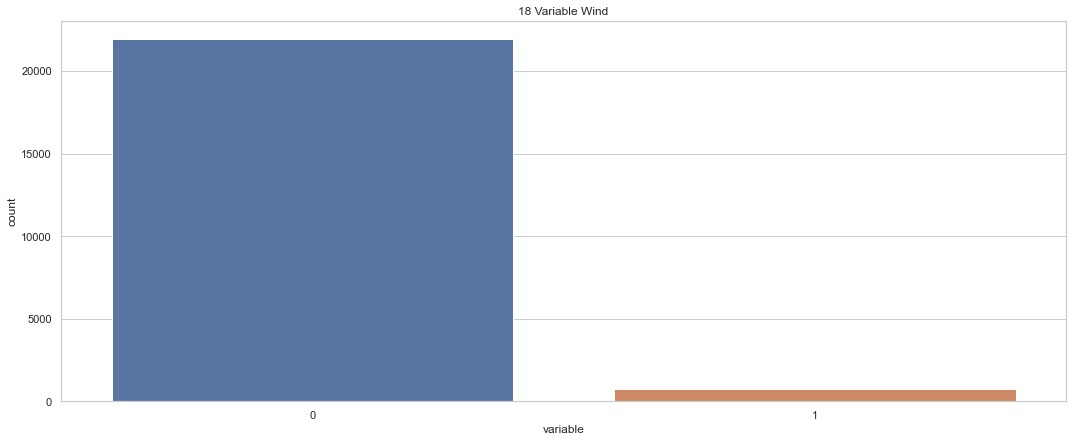

In [41]:
print(s_df['variable'].value_counts())

sns.countplot(data = s_df, x = 'variable').set(title = '18 Variable Wind')

DFront     18460
Lateral    12989
Front      12524
DTail       5906
Tail        5305
Name: direction, dtype: int64


[Text(0.5, 1.0, '32 Wind Direction')]

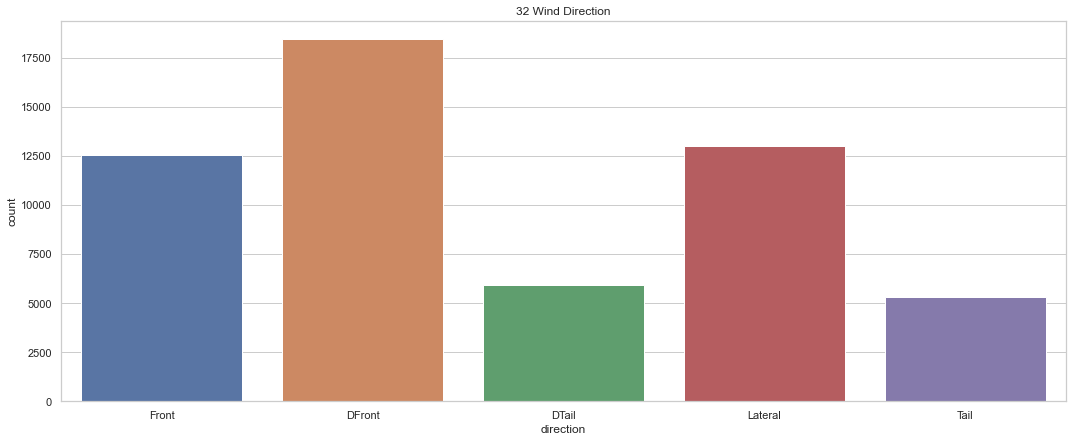

In [42]:
print(n_df['direction'].value_counts())

sns.countplot(data = n_df, x = 'direction', order = ['Front', 'DFront', 'DTail', 'Lateral', 'Tail']).set(title = '32 Wind Direction')

Front      9735
DFront     9542
Lateral    2000
Tail       1092
DTail       290
Name: direction, dtype: int64


[Text(0.5, 1.0, '18 Wind Direction')]

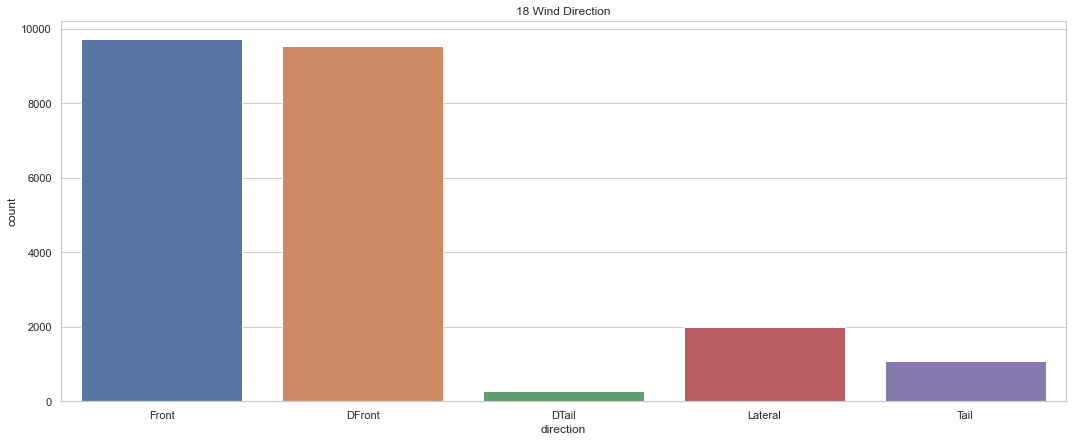

In [43]:
print(s_df['direction'].value_counts())

sns.countplot(data = s_df, x = 'direction', order = ['Front', 'DFront', 'DTail', 'Lateral', 'Tail']).set(title = '18 Wind Direction')

              knots
count  55184.000000
mean       5.053621
std        4.051774
min        0.000000
25%        2.000000
50%        4.000000
75%        7.000000
max       31.000000


<AxesSubplot:xlabel='knots'>

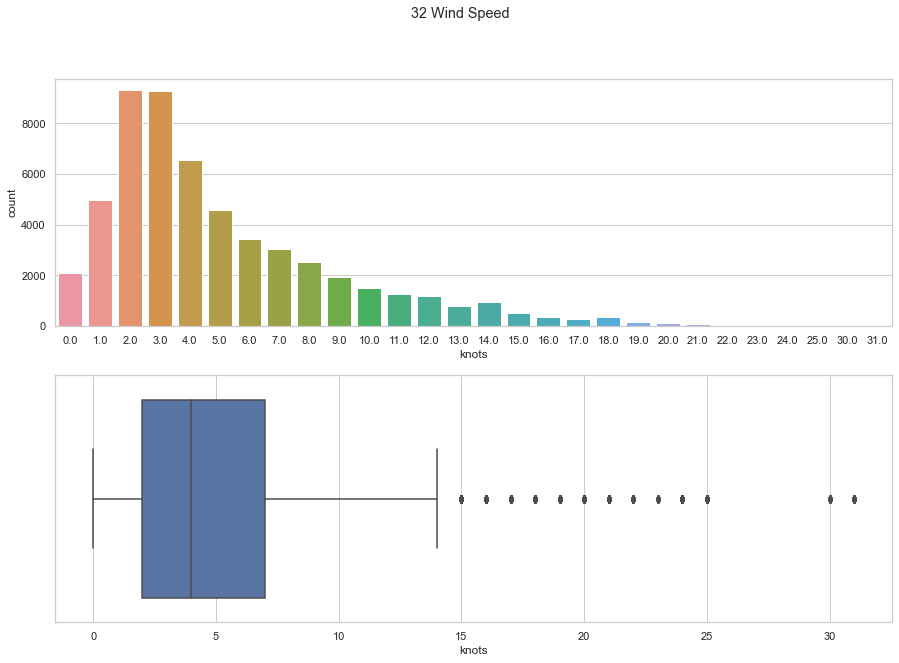

In [44]:
print(n_df[['knots']].describe())

fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(15, 10))
fig.suptitle('32 Wind Speed')
sns.countplot(data = n_df, x = 'knots', ax = axes[0])
sns.boxplot(data = n_df, x = 'knots', ax = axes[1])

              knots
count  22659.000000
mean       9.308707
std        4.916020
min        0.000000
25%        6.000000
50%        9.000000
75%       12.000000
max       30.000000


<AxesSubplot:xlabel='knots'>

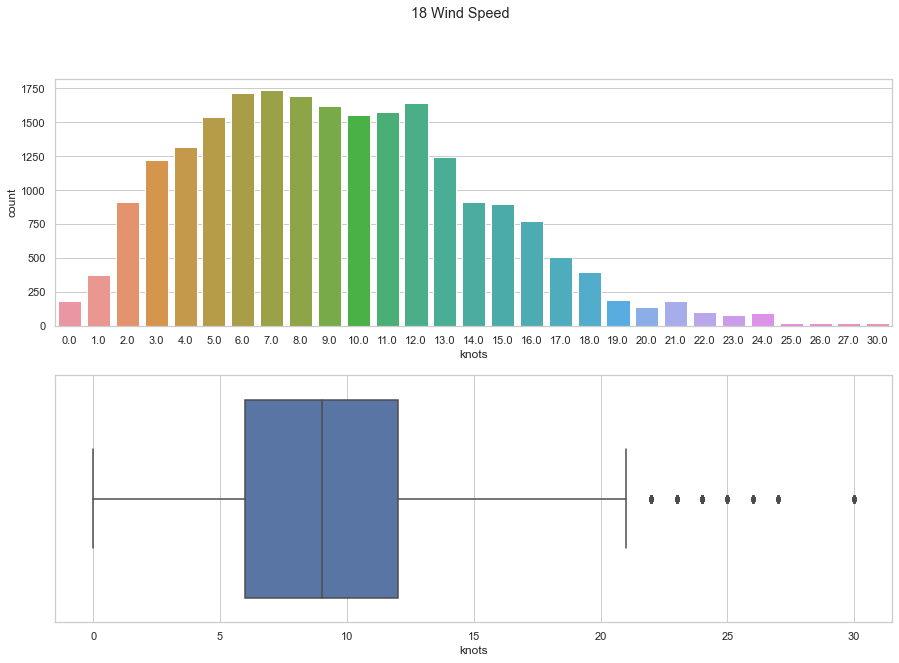

In [45]:
print(s_df[['knots']].describe())

fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(15, 10))
fig.suptitle('18 Wind Speed')
sns.countplot(data = s_df, x = 'knots', ax = axes[0])
sns.boxplot(data = s_df, x = 'knots', ax = axes[1])

       knotsVariability
count      55184.000000
mean           5.156785
std            0.948786
min            5.000000
25%            5.000000
50%            5.000000
75%            5.000000
max           16.000000


<AxesSubplot:xlabel='knotsVariability'>

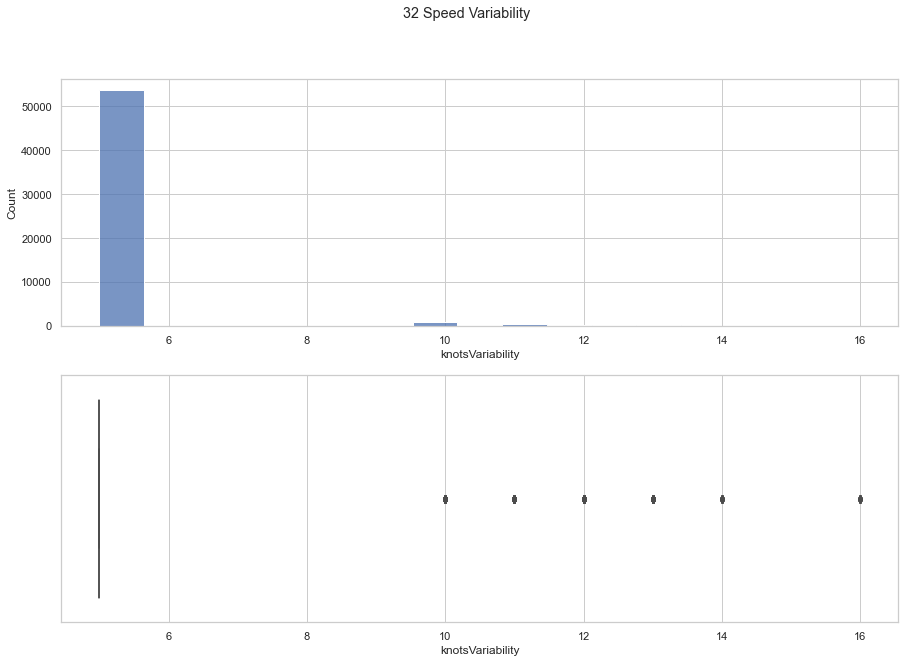

In [46]:
print(n_df[['knotsVariability']].describe())

fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(15, 10))
fig.suptitle('32 Speed Variability')
sns.histplot(data = n_df, x = 'knotsVariability', ax = axes[0])
sns.boxplot(data = n_df, x = 'knotsVariability', ax = axes[1])

       knotsVariability
count      22659.000000
mean           6.187343
std            2.693641
min            5.000000
25%            5.000000
50%            5.000000
75%            5.000000
max           19.000000


<AxesSubplot:xlabel='knotsVariability'>

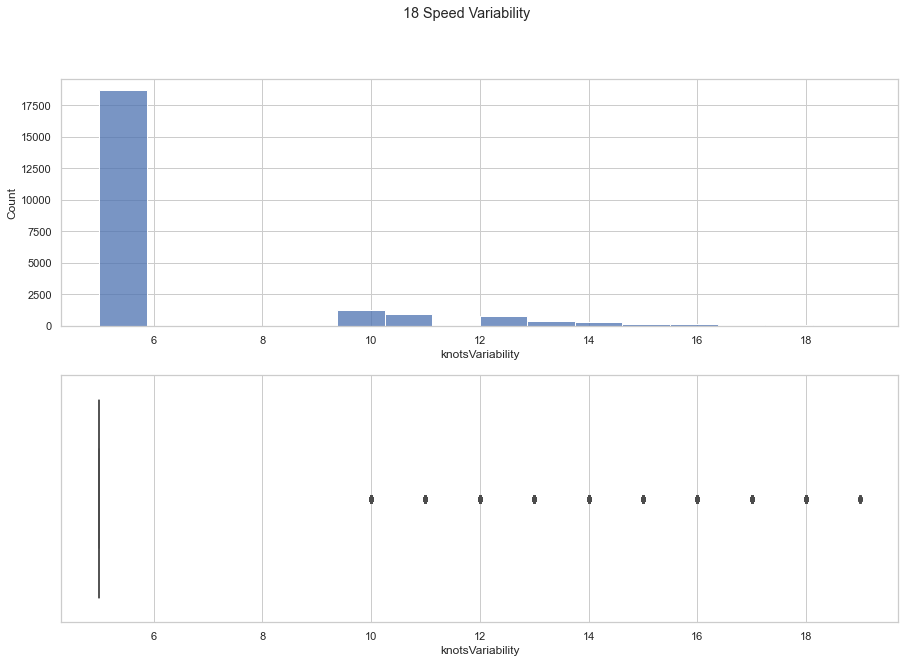

In [47]:
print(s_df[['knotsVariability']].describe())

fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(15, 10))
fig.suptitle('18 Speed Variability')
sns.histplot(data = s_df, x = 'knotsVariability', ax = axes[0])
sns.boxplot(data = s_df, x = 'knotsVariability', ax = axes[1])

0.0    54423
1.0      761
Name: shear, dtype: int64


[Text(0.5, 1.0, '32 Shear')]

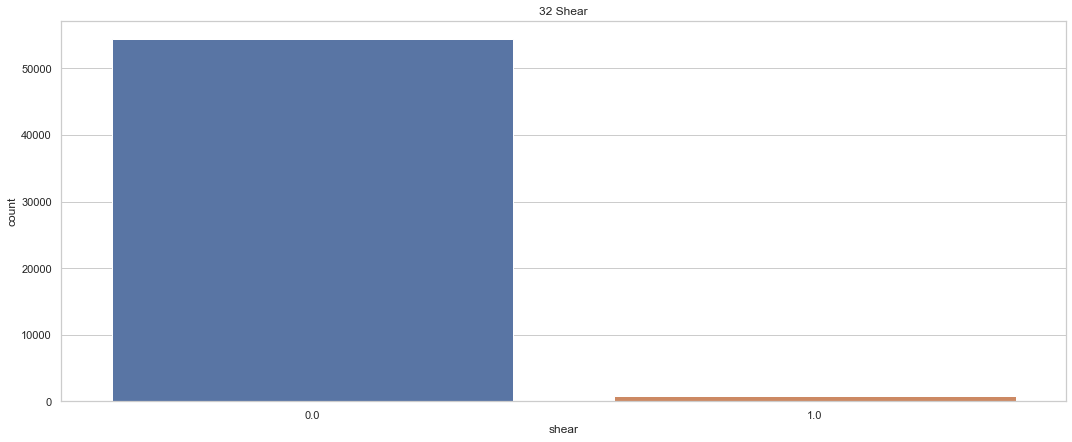

In [48]:
print(n_df['shear'].value_counts())

sns.countplot(data = n_df, x = 'shear').set(title = '32 Shear')

0.0    22036
1.0      623
Name: shear, dtype: int64


[Text(0.5, 1.0, '18 Shear')]

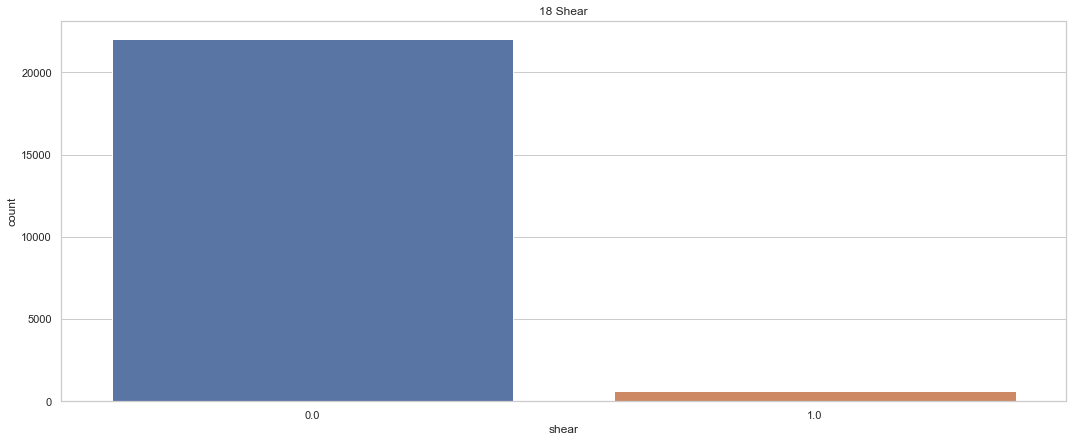

In [49]:
print(s_df['shear'].value_counts())

sns.countplot(data = s_df, x = 'shear').set(title = '18 Shear')

0.0    52513
2.0     1993
1.0      678
Name: coverage, dtype: int64


[Text(0.5, 1.0, '32 Coverage Type')]

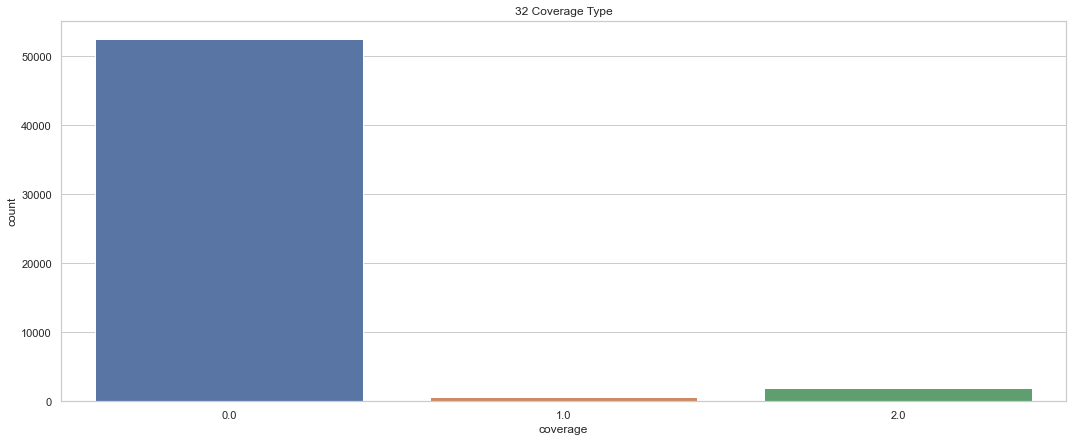

In [50]:
print(n_df['coverage'].value_counts())

sns.countplot(data = n_df, x = 'coverage').set(title = '32 Coverage Type')

0.0    20664
2.0     1158
1.0      837
Name: coverage, dtype: int64


[Text(0.5, 1.0, '18 Coverage Type')]

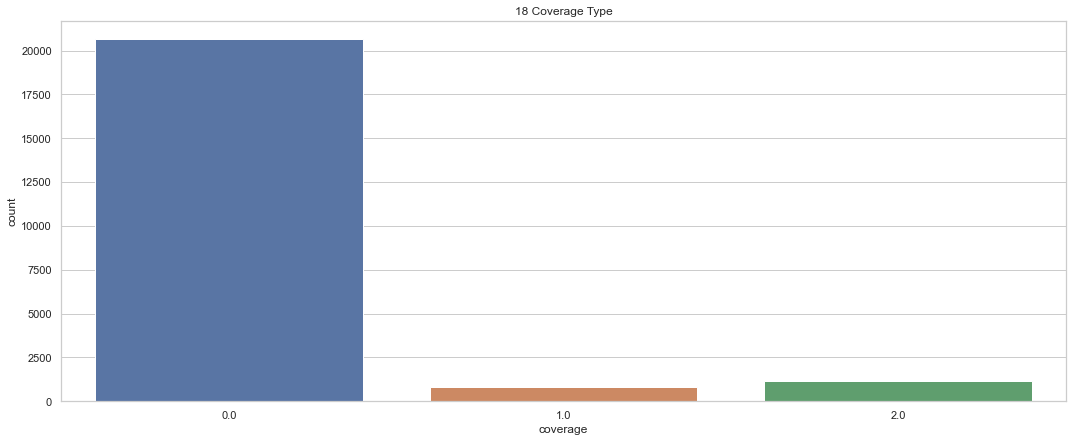

In [51]:
print(s_df['coverage'].value_counts())

sns.countplot(data = s_df, x = 'coverage').set(title = '18 Coverage Type')

0    36568
1    18616
Name: anyClouds, dtype: int64


[Text(0.5, 1.0, '32 Exisitng Clouds')]

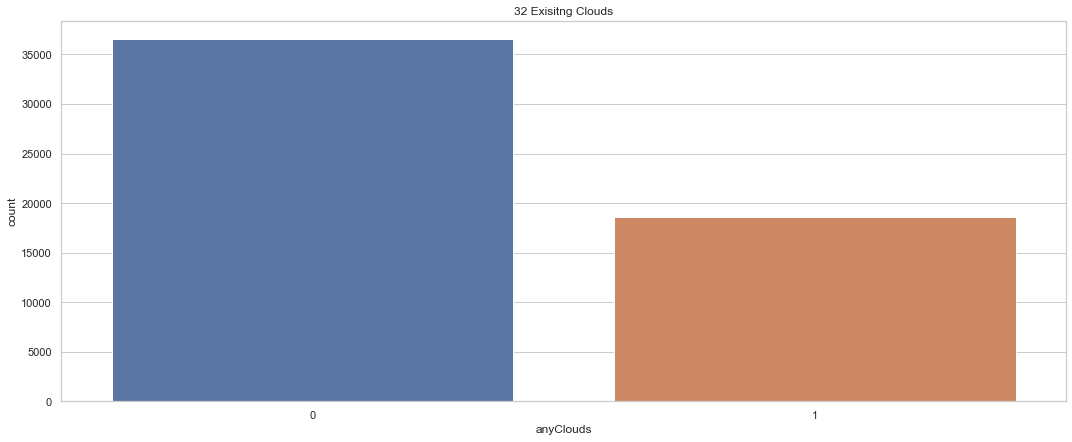

In [52]:
print(n_df['anyClouds'].value_counts())

sns.countplot(data = n_df, x = 'anyClouds').set(title = '32 Exisitng Clouds')

0    11973
1    10686
Name: anyClouds, dtype: int64


[Text(0.5, 1.0, '18 Exisitng Clouds')]

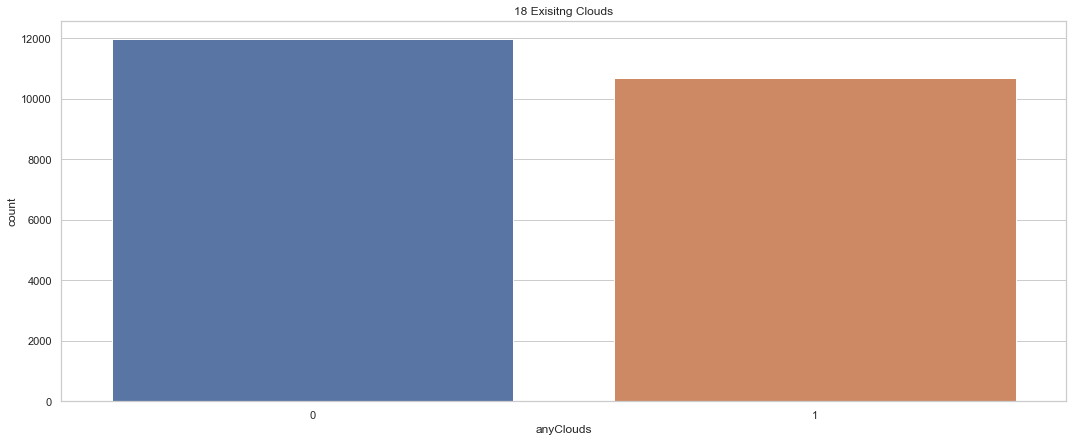

In [53]:
print(s_df['anyClouds'].value_counts())

sns.countplot(data = s_df, x = 'anyClouds').set(title = '18 Exisitng Clouds')

0.0    37038
1.0    11694
2.0     4754
3.0     1366
4.0      332
Name: min_height_amount, dtype: int64
         min_height
count  55184.000000
mean     686.643176
std      446.435668
min        1.000000
25%       70.000000
50%      999.000000
75%      999.000000
max      999.000000


<AxesSubplot:xlabel='min_height'>

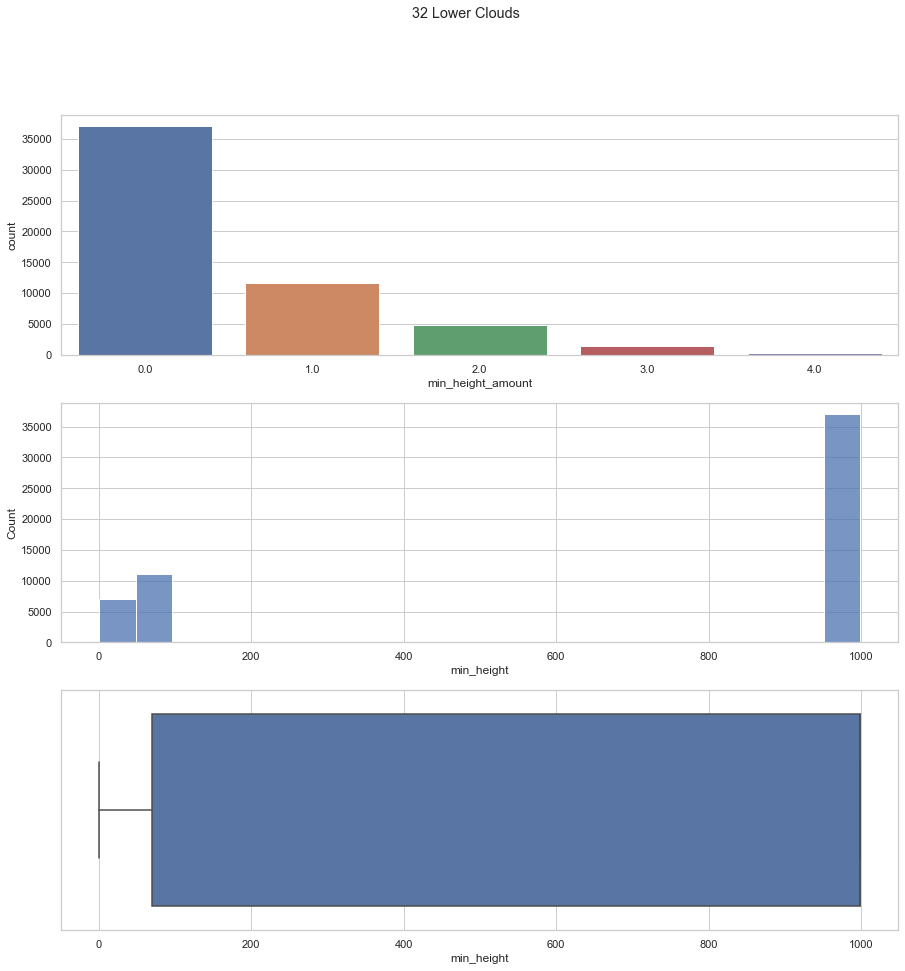

In [54]:
print(n_df['min_height_amount'].value_counts())
print(n_df[['min_height']].describe())

fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize=(15, 15))
fig.suptitle('32 Lower Clouds')
sns.countplot(data = n_df, x = 'min_height_amount', ax = axes[0])
sns.histplot(data = n_df, x = 'min_height', ax = axes[1])
sns.boxplot(data = n_df, x = 'min_height', ax = axes[2])

0.0    11973
1.0     6154
2.0     3249
3.0     1202
4.0       81
Name: min_height_amount, dtype: int64
         min_height
count  22659.000000
mean     547.122556
std      478.575976
min        1.000000
25%       40.000000
50%      999.000000
75%      999.000000
max      999.000000


<AxesSubplot:xlabel='min_height'>

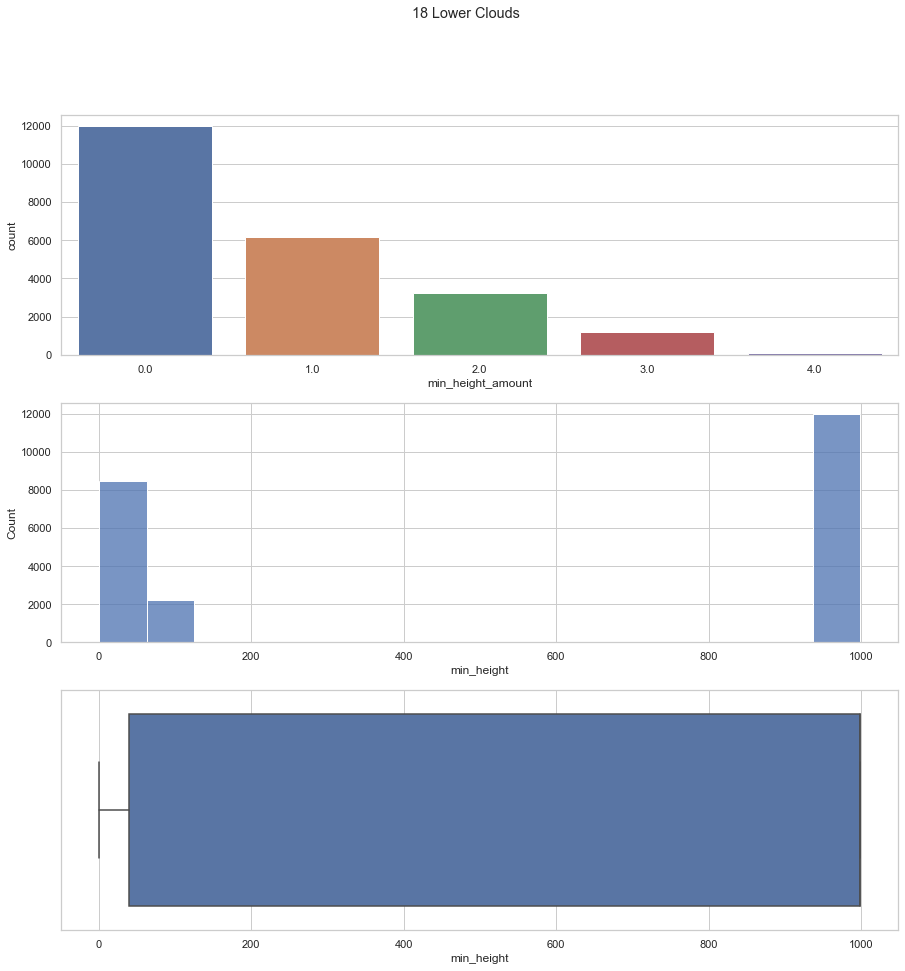

In [55]:
print(s_df['min_height_amount'].value_counts())
print(s_df[['min_height']].describe())

fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize=(15, 15))
fig.suptitle('18 Lower Clouds')
sns.countplot(data = s_df, x = 'min_height_amount', ax = axes[0])
sns.histplot(data = s_df, x = 'min_height', ax = axes[1])
sns.boxplot(data = s_df, x = 'min_height', ax = axes[2])

0.0    37038
1.0     9012
2.0     4524
3.0     3919
4.0      691
Name: max_amount, dtype: int64
       max_amount_height
count       55184.000000
mean          688.333484
std           443.987088
min             1.000000
25%            70.000000
50%           999.000000
75%           999.000000
max           999.000000


<AxesSubplot:xlabel='max_amount_height'>

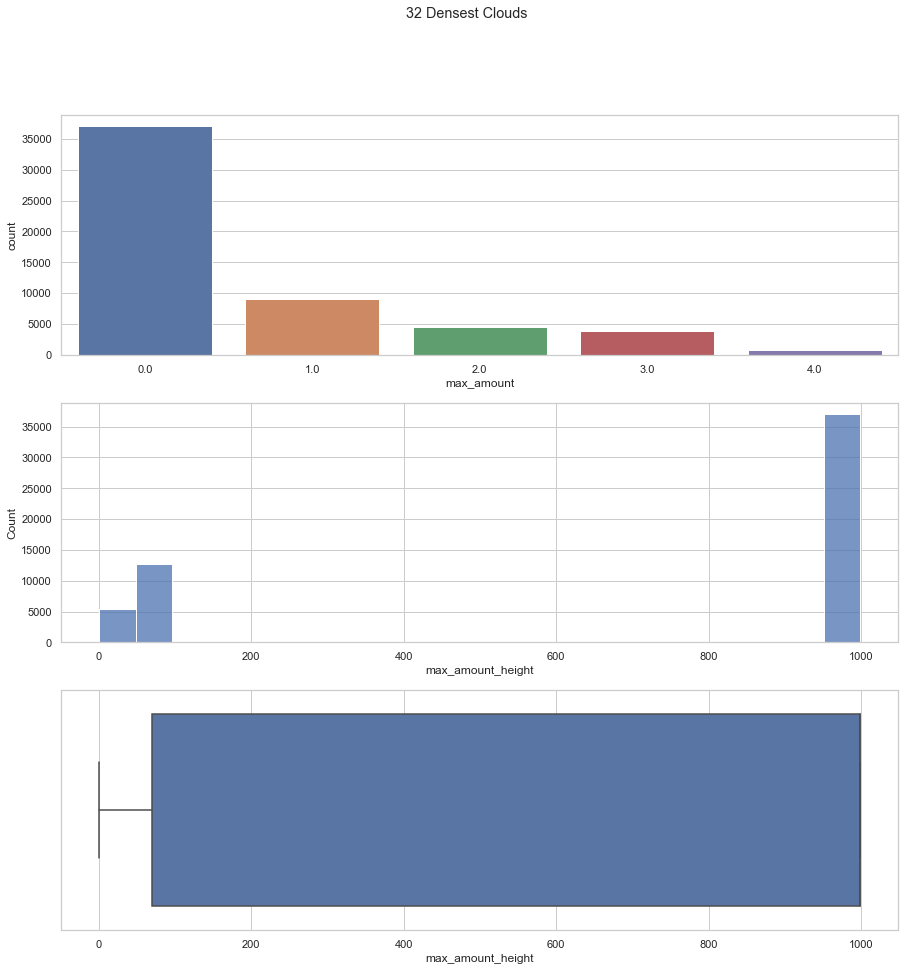

In [56]:
print(n_df['max_amount'].value_counts())
print(n_df[['max_amount_height']].describe())

fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize=(15, 15))
fig.suptitle('32 Densest Clouds')
sns.countplot(data = n_df, x = 'max_amount', ax = axes[0])
sns.histplot(data = n_df, x = 'max_amount_height', ax = axes[1])
sns.boxplot(data = n_df, x = 'max_amount_height', ax = axes[2])

0.0    11973
3.0     3884
1.0     3877
2.0     2564
4.0      361
Name: max_amount, dtype: int64
       max_amount_height
count       22659.000000
mean          551.499095
std           473.892605
min             4.000000
25%            50.000000
50%           999.000000
75%           999.000000
max           999.000000


<AxesSubplot:xlabel='max_amount_height'>

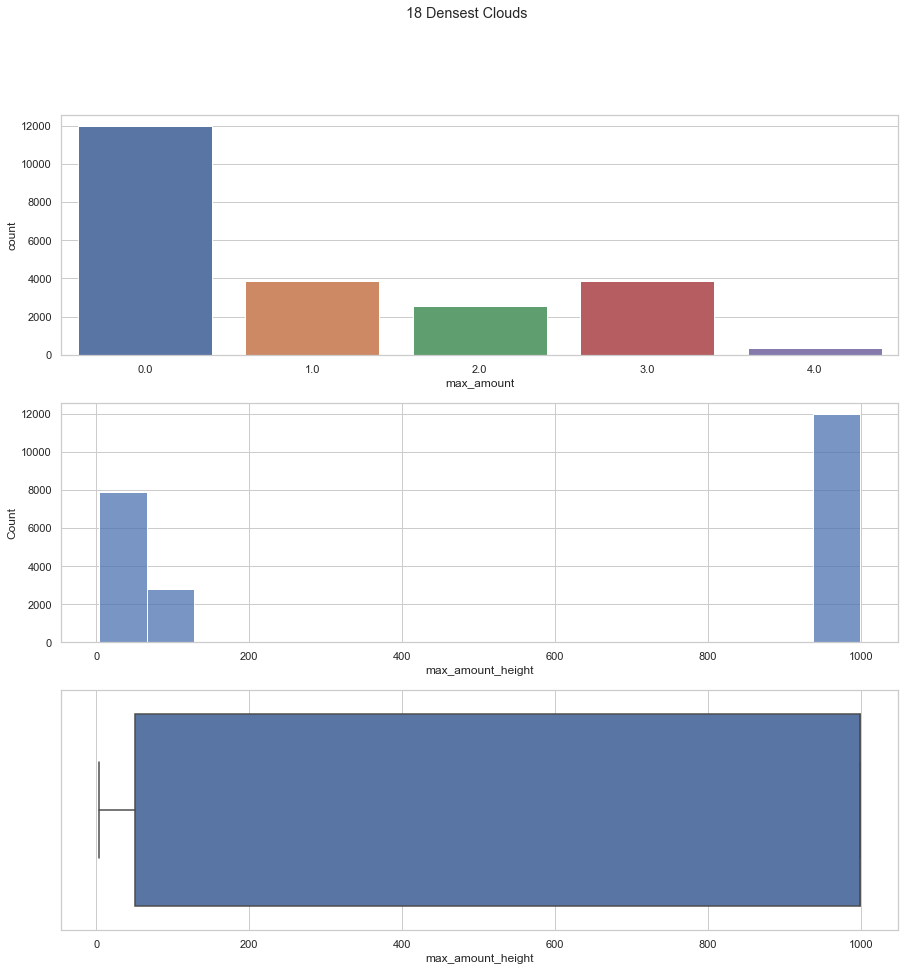

In [57]:
print(s_df['max_amount'].value_counts())
print(s_df[['max_amount_height']].describe())

fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize=(15, 15))
fig.suptitle('18 Densest Clouds')
sns.countplot(data = s_df, x = 'max_amount', ax = axes[0])
sns.histplot(data = s_df, x = 'max_amount_height', ax = axes[1])
sns.boxplot(data = s_df, x = 'max_amount_height', ax = axes[2])

0    53862
1     1322
Name: significantClouds, dtype: int64


[Text(0.5, 1.0, '32 Significant Clouds')]

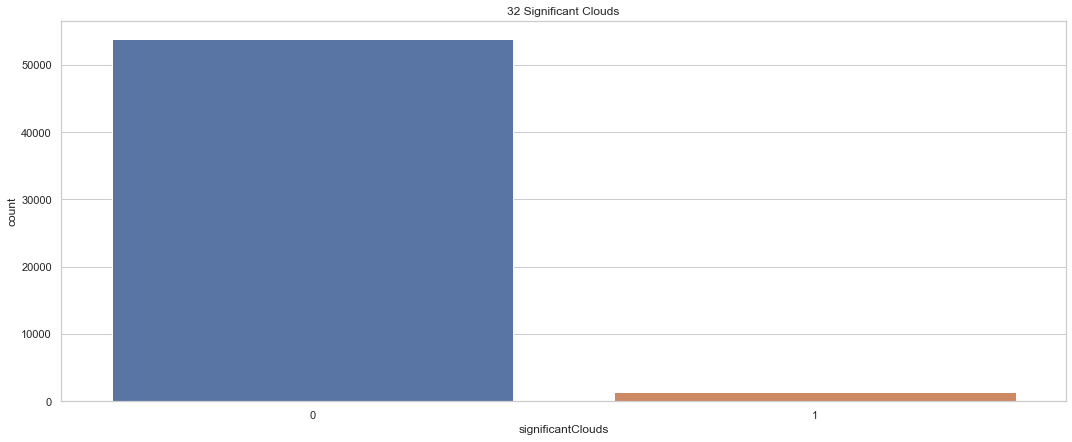

In [58]:
print(n_df['significantClouds'].value_counts())

sns.countplot(data = n_df, x = 'significantClouds').set(title = '32 Significant Clouds')

0    22011
1      648
Name: significantClouds, dtype: int64


[Text(0.5, 1.0, '18 Significant Clouds')]

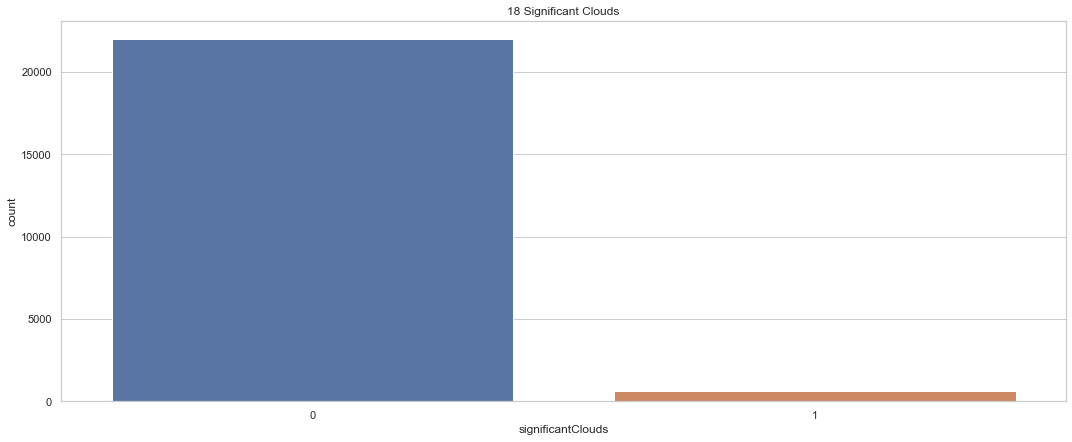

In [59]:
print(s_df['significantClouds'].value_counts())

sns.countplot(data = s_df, x = 'significantClouds').set(title = '18 Significant Clouds')

0.0    53866
1.0      985
2.0      314
3.0       19
Name: Lluvia, dtype: int64


[Text(0.5, 1.0, '32 Lluvia')]

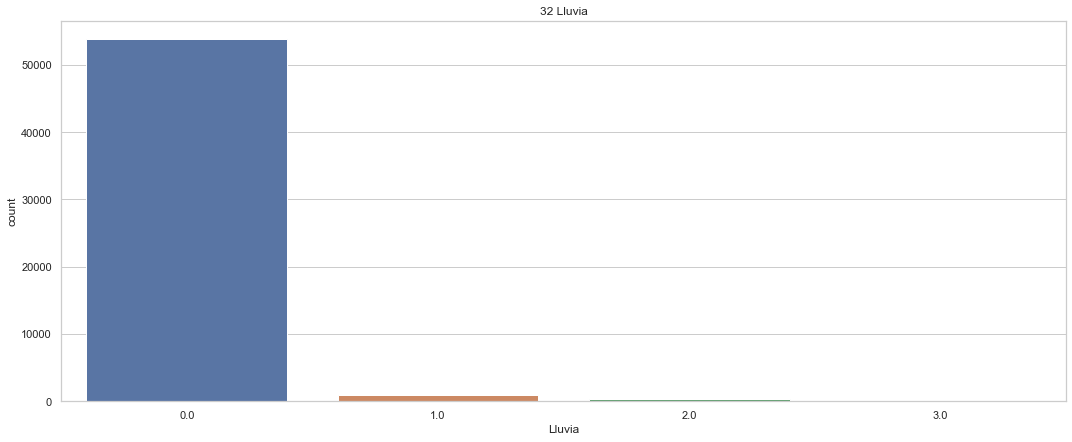

In [60]:
print(n_df['Lluvia'].value_counts())

sns.countplot(data = n_df, x = 'Lluvia').set(title = '32 Lluvia')

0.0    21160
1.0      978
2.0      521
Name: Lluvia, dtype: int64


[Text(0.5, 1.0, '18 Lluvia')]

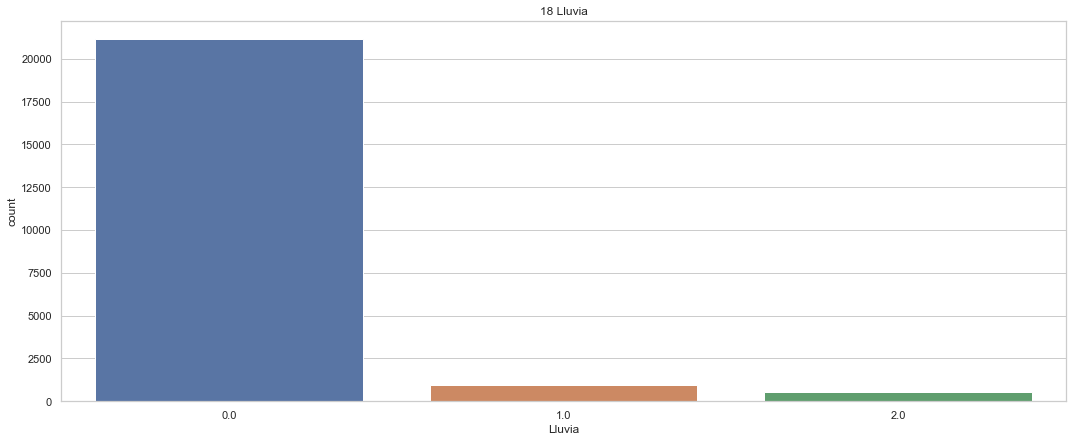

In [61]:
print(s_df['Lluvia'].value_counts())

sns.countplot(data = s_df, x = 'Lluvia').set(title = '18 Lluvia')

0.0    54326
2.0      858
Name: Niebla, dtype: int64


[Text(0.5, 1.0, '32 Niebla')]

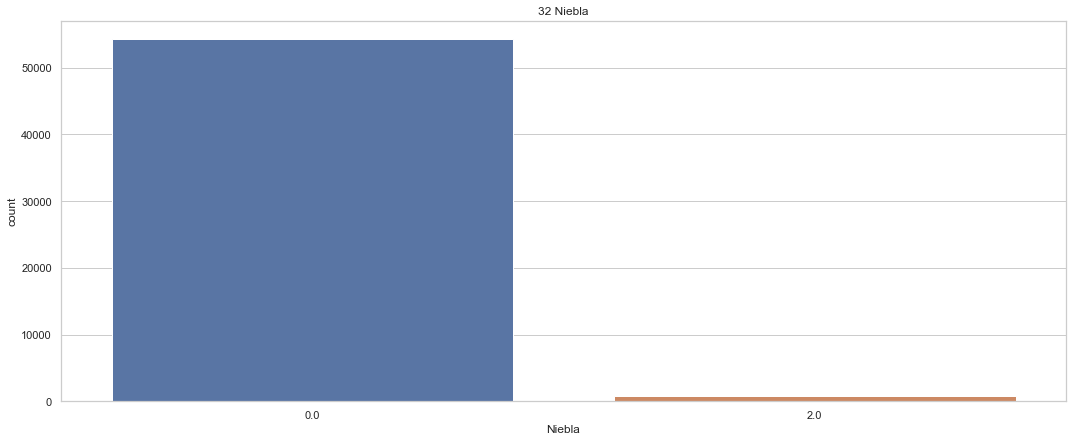

In [62]:
print(n_df['Niebla'].value_counts())

sns.countplot(data = n_df, x = 'Niebla').set(title = '32 Niebla')

0.0    22603
2.0       56
Name: Niebla, dtype: int64


[Text(0.5, 1.0, '18 Niebla')]

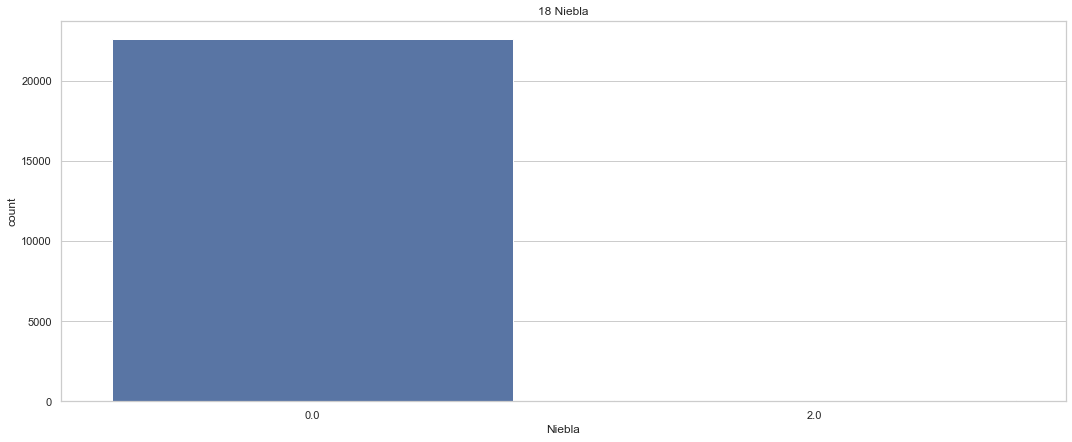

In [63]:
print(s_df['Niebla'].value_counts())

sns.countplot(data = s_df, x = 'Niebla').set(title = '18 Niebla')

0.0    55084
2.0       77
1.0       23
Name: Tormenta, dtype: int64


[Text(0.5, 1.0, '32 Tormenta')]

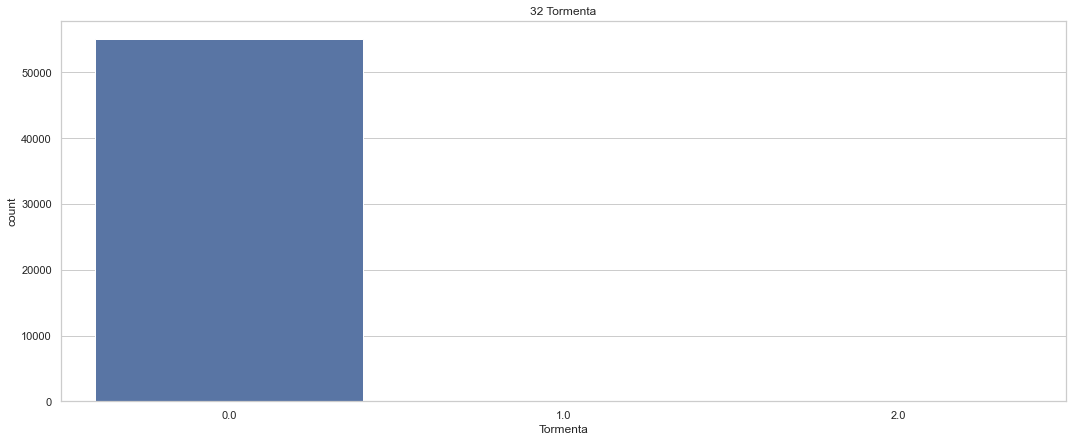

In [64]:
print(n_df['Tormenta'].value_counts())

sns.countplot(data = n_df, x = 'Tormenta').set(title = '32 Tormenta')

0.0    22585
2.0       74
Name: Tormenta, dtype: int64


[Text(0.5, 1.0, '18 Tormenta')]

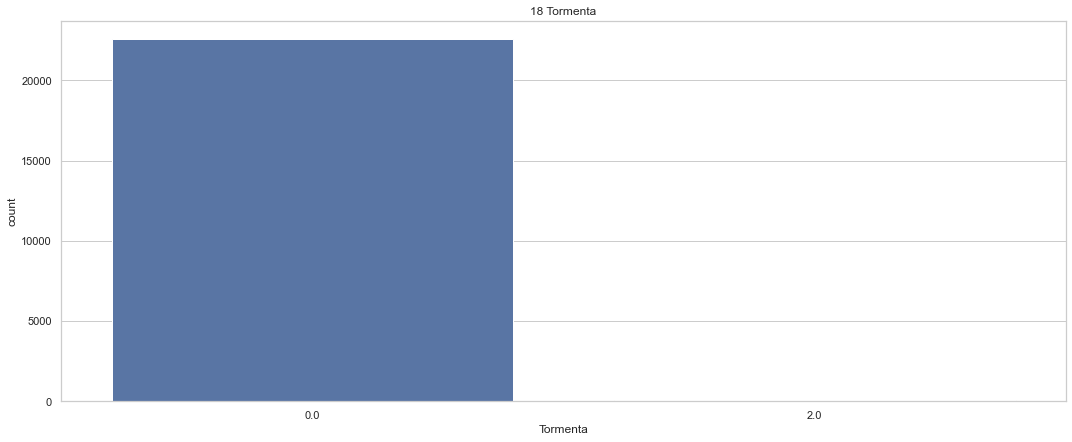

In [65]:
print(s_df['Tormenta'].value_counts())

sns.countplot(data = s_df, x = 'Tormenta').set(title = '18 Tormenta')

In [66]:
n_df.to_csv('Runway32.csv', decimal = ',', sep = ';', index = False)
s_df.to_csv('Runway18.csv', decimal = ',', sep = ';', index = False)